## Imports and Helper Functions 

In [1]:
# Cell 1: Imports and Helper Functions
import pandas as pd
import numpy as np
import ast # For safely evaluating string-formatted lists
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder # Added LabelEncoder
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin # For custom estimators
from scipy.stats import mode as scipy_mode # For MajorityClassClassifier

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import pearsonr

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
import re # For extract_checklist_ids
from checklist_prompt import ChecklistPrompt

# Helper function to extract checklist item IDs (e.g., A1, B1)
def extract_checklist_ids(checklist_string):
    ids = []
    for line in checklist_string.strip().split('\n'):
        # Regex to find patterns like "[ ] A1", "[+] A1", "[-] A1"
        match = re.search(r'\[\s*[+-]?\s*\]\s*([A-Z]\d+)', line)
        if match:
            ids.append(match.group(1))
    return ids

# Extract item IDs for each category
compliance_item_ids = extract_checklist_ids(ChecklistPrompt.compliance_list)
contribution_item_ids = extract_checklist_ids(ChecklistPrompt.contribution_list)
soundness_item_ids = extract_checklist_ids(ChecklistPrompt.soundness_list)
presentation_item_ids = extract_checklist_ids(ChecklistPrompt.presentation_list)

# Concatenate all item IDs to form the full list of feature names
# ALL_FEATURE_ITEM_IDS = compliance_item_ids + contribution_item_ids + soundness_item_ids + presentation_item_ids
ALL_FEATURE_ITEM_IDS = compliance_item_ids

# This global variable will be used for X's column names and feature importance plotting
FEATURE_NAMES_FOR_PLOTTING = ALL_FEATURE_ITEM_IDS


# Helper function to parse stringified list of HUMAN scores and calculate mean
def parse_human_score_list_and_mean(series_val):
    try:
        # Ensure it's a string, then evaluate
        if isinstance(series_val, str):
            actual_list = ast.literal_eval(series_val)
            if isinstance(actual_list, list) and len(actual_list) > 0:
                # Convert elements to float before calculating mean
                numeric_list = [float(i) for i in actual_list if isinstance(i, (int, float, str)) and str(i).replace('.', '', 1).replace('-', '', 1).isdigit()]
                if numeric_list:
                    return np.mean(numeric_list)
                else: # handles list of non-numeric strings or empty after filtering
                    return np.nan 
            else: # Not a list or empty list
                return np.nan
        elif isinstance(series_val, (list, np.ndarray)): # Already a list
             if len(series_val) > 0:
                numeric_list = [float(i) for i in series_val if isinstance(i, (int, float, str)) and str(i).replace('.', '', 1).replace('-', '', 1).isdigit()]
                if numeric_list:
                    return np.mean(numeric_list)
                else:
                    return np.nan
             else:
                return np.nan
        elif isinstance(series_val, (int, float)): # Already a number
            return float(series_val)
        else: # Other types or unparsable
            return np.nan
    except (ValueError, SyntaxError, TypeError):
        return np.nan # Return NaN if parsing fails

# Helper function to parse stringified list of AUTOMATED scores (e.g., compliance_score)
# into a list of integers, padding/truncating to an expected length.
def parse_string_to_list_of_scores(s_list_val, expected_len=None):
    if pd.isna(s_list_val):
        return [np.nan] * expected_len if expected_len is not None else []
    
    parsed_list = []
    try:
        if isinstance(s_list_val, str):
            actual_list_from_string = ast.literal_eval(s_list_val)
        elif isinstance(s_list_val, (list, np.ndarray)):
            actual_list_from_string = list(s_list_val)
        elif isinstance(s_list_val, (int, float)): # Single number treated as a list of one
             actual_list_from_string = [s_list_val]
        else: # Cannot parse
            return [np.nan] * expected_len if expected_len is not None else []

        if not isinstance(actual_list_from_string, list):
             return [np.nan] * expected_len if expected_len is not None else []

        for item in actual_list_from_string:
            try:
                # Scores are typically integers like -1, 0, 1.
                # Convert to float first to handle cases like "1.0", then to int.
                parsed_list.append(int(float(item)))
            except (ValueError, TypeError):
                parsed_list.append(np.nan) # Non-numeric items become NaN
    
    except (SyntaxError, ValueError, TypeError): # Error during ast.literal_eval or list processing
        return [np.nan] * expected_len if expected_len is not None else []

    # Pad or truncate to expected_len
    if expected_len is not None:
        if len(parsed_list) < expected_len:
            parsed_list.extend([np.nan] * (expected_len - len(parsed_list))) # Pad with NaN
        elif len(parsed_list) > expected_len:
            parsed_list = parsed_list[:expected_len] # Truncate
            
    return parsed_list


# --- Custom Baseline Estimators ---
class MeanPredictorRegressor(BaseEstimator, RegressorMixin):
    """
    A simple baseline regressor that predicts the mean of the training target.
    """
    def __init__(self):
        self.mean_val_ = 0

    def fit(self, X, y):
        self.mean_val_ = np.mean(y)
        return self

    def predict(self, X):
        return np.full(X.shape[0], self.mean_val_)

class MajorityClassClassifier(BaseEstimator, ClassifierMixin):
    """
    A simple baseline classifier that predicts the majority class of the training target.
    """
    def __init__(self):
        self.majority_class_ = None
        self.classes_ = None
        self.majority_class_proba_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if len(self.classes_) == 0: # Handle empty y
            self.majority_class_ = 0 # Default or raise error
            self.majority_class_proba_ = {c: 0.0 for c in self.classes_}
            if self.classes_.size > 0 : self.majority_class_proba_[self.classes_[0]] = 1.0 # Default if possible
            return self

        self.majority_class_ = scipy_mode(y)[0]
        
        # Calculate probabilities for predict_proba
        # Ensure y is integer for bincount and handle potential non-numeric or out-of-bounds values gracefully
        y_int = y.astype(int)
        min_y, max_y = y_int.min(), y_int.max()
        
        # Adjust bincount to handle potentially negative or large class labels if they are not 0-indexed
        if min_y < 0 : # Shift if negative labels
            y_shifted = y_int - min_y
            counts = np.bincount(y_shifted)
            self.majority_class_proba_ = {
                cls_val: counts[cls_val - min_y] / len(y) if (cls_val - min_y) < len(counts) and (cls_val - min_y) >=0 else 0.0
                for cls_val in self.classes_
            }
        else: # Non-negative labels
            counts = np.bincount(y_int)
            self.majority_class_proba_ = {
                cls_val: counts[cls_val] / len(y) if cls_val < len(counts) else 0.0
                for cls_val in self.classes_
            }
        
        # Ensure all classes from np.unique(y) have a probability, even if zero
        for cls_val in self.classes_:
            if cls_val not in self.majority_class_proba_:
                self.majority_class_proba_[cls_val] = 0.0
        return self

    def predict(self, X):
        if self.majority_class_ is None:
            raise ValueError("Estimator has not been fitted.")
        return np.full(X.shape[0], self.majority_class_)

    def predict_proba(self, X):
        if self.majority_class_ is None or self.classes_ is None:
            raise ValueError("Estimator has not been fitted.")
        
        n_samples = X.shape[0]
        # Ensure self.classes_ is sorted for consistent column order in predict_proba output
        sorted_classes = np.sort(self.classes_)
        proba = np.zeros((n_samples, len(sorted_classes)))

        for i, cls_val in enumerate(sorted_classes):
            proba[:, i] = self.majority_class_proba_.get(cls_val, 0.0)
            
        # For this simple majority classifier, one class gets (nearly) all probability.
        # Normalization might be needed if probabilities don't sum to 1 due to floating point issues
        # or if the logic for self.majority_class_proba_ is complex.
        # For this specific implementation, it should be fine.
        sum_proba = np.sum(proba, axis=1, keepdims=True)
        # Avoid division by zero if all probabilities are zero for a sample (shouldn't happen if fitted)
        sum_proba[sum_proba == 0] = 1 
        proba = proba / sum_proba

        return proba

## Load Data and Initial Preprocessing

In [4]:
from ast import literal_eval

df = pd.read_csv('ICLR2024_scores.csv')

# Raw feature columns from CSV (containing stringified lists)
feature_cols_raw = ['compliance_score', 'contribution_score', 'soundness_score', 'presentation_score']
# Target columns (human scores)
target_cols_raw_regression = ['human_rating', 'human_soundness', 'human_contribution', 'human_presentation']
target_col_ethics = 'ethics_flag' # Renamed for clarity
target_col_decision_raw = 'decision' # Original decision column

# Define expected lengths for each feature score list based on ChecklistPrompt item IDs
expected_lengths = {
    'compliance_score': len(compliance_item_ids),
    # 'contribution_score': len(contribution_item_ids),
    # 'soundness_score': len(soundness_item_ids),
    # 'presentation_score': len(presentation_item_ids)
}
print(f"Expected lengths for feature lists: {expected_lengths}")

all_parsed_row_features = []
for index, row in df.iterrows():
    concatenated_row_features = []
    concatenated_row_features.extend(parse_string_to_list_of_scores(row['compliance_score'], expected_lengths['compliance_score']))
    # concatenated_row_features.extend(parse_string_to_list_of_scores(row['contribution_score'], expected_lengths['contribution_score']))
    # concatenated_row_features.extend(parse_string_to_list_of_scores(row['soundness_score'], expected_lengths['soundness_score']))
    # concatenated_row_features.extend(parse_string_to_list_of_scores(row['presentation_score'], expected_lengths['presentation_score']))
    all_parsed_row_features.append(concatenated_row_features)

X = pd.DataFrame(all_parsed_row_features, columns=ALL_FEATURE_ITEM_IDS, index=df.index)
print(f"Shape of X (features): {X.shape}")

processed_target_cols_regression = []
for col in target_cols_raw_regression:
    processed_col_name = f'{col}_mean'
    df[processed_col_name] = df[col].apply(parse_human_score_list_and_mean)
    processed_target_cols_regression.append(processed_col_name)

df[target_col_ethics] = df[target_col_ethics].astype(int)

# Encode 'decision' column
le = LabelEncoder()
df['decision_encoded'] = le.fit_transform(df[target_col_decision_raw])
decision_mapping = {label: index for index, label in enumerate(le.classes_)}
print(f"Decision mapping: {decision_mapping}") # e.g., {'accepted': 0, 'rejected': 1} or vice-versa
target_col_decision_encoded = 'decision_encoded'


# Combine X with processed targets and original decision for consistent NaN dropping
# Note: df_processed will now use target_col_decision_raw for stratification in Cell 3,
# but target_col_decision_encoded for model training.
df_processed = pd.concat([X, 
                            df[processed_target_cols_regression + \
                                [target_col_ethics, target_col_decision_encoded, target_col_decision_raw]]], axis=1)

# Drop rows with ANY NaN 
df_processed.dropna(subset=ALL_FEATURE_ITEM_IDS + \
                            processed_target_cols_regression + \
                            [target_col_ethics, target_col_decision_encoded], inplace=True)

print(f"Data shape after processing and NaN removal: {df_processed.shape}")

if df_processed.empty:
    print("DataFrame is empty after processing and NaN removal. Cannot proceed.")
    X, y_regression = pd.DataFrame(), pd.DataFrame()
    y_classification_ethics, y_classification_decision = pd.Series(dtype='int'), pd.Series(dtype='int')
    decision_column_for_stratify = pd.Series(dtype='object')
else:
    print(f"Processed data sample (first 5 rows, first 5 features of X, and targets):")
    display_cols = ALL_FEATURE_ITEM_IDS[:5] + \
                    processed_target_cols_regression + \
                    [target_col_ethics, target_col_decision_encoded, target_col_decision_raw]
    print(df_processed[display_cols].head())
    
    X = df_processed[ALL_FEATURE_ITEM_IDS]
    y_regression = df_processed[processed_target_cols_regression]
    y_classification_ethics = df_processed[target_col_ethics]
    y_classification_decision = df_processed[target_col_decision_encoded]
    decision_column_for_stratify = df_processed[target_col_decision_raw] # Used for stratification



Expected lengths for feature lists: {'compliance_score': 36}
Shape of X (features): (1442, 36)
Decision mapping: {'accepted': 0, 'rejected': 1}
Data shape after processing and NaN removal: (1349, 43)
Processed data sample (first 5 rows, first 5 features of X, and targets):
    A1   A2   A3   A4   A5  human_rating_mean  human_soundness_mean  \
0 -1.0 -1.0 -1.0 -1.0 -1.0               5.75                  3.25   
1 -1.0 -1.0 -1.0 -1.0 -1.0               6.40                  2.80   
2 -1.0 -1.0 -1.0 -1.0  1.0               7.00                  3.00   
5 -1.0 -1.0 -1.0 -1.0 -1.0               5.50                  3.00   
6 -1.0 -1.0 -1.0 -1.0  1.0               6.75                  3.00   

   human_contribution_mean  human_presentation_mean  ethics_flag  \
0                      2.5                     3.25            0   
1                      2.8                     2.80            0   
2                      3.0                     3.00            0   
5                      2.5 

## Stratified Data Splitting (50/50 accepted/rejected)

In [5]:
if not X.empty and not decision_column_for_stratify.empty:
    
    temp_df_for_splitting = X.copy() 
    temp_df_for_splitting[processed_target_cols_regression] = y_regression 
    temp_df_for_splitting[target_col_ethics] = y_classification_ethics 
    temp_df_for_splitting[target_col_decision_encoded] = y_classification_decision
    temp_df_for_splitting[target_col_decision_raw] = decision_column_for_stratify # This is what we stratify on

    df_accepted = temp_df_for_splitting[temp_df_for_splitting[target_col_decision_raw] == 'accepted']
    df_rejected = temp_df_for_splitting[temp_df_for_splitting[target_col_decision_raw] == 'rejected']

    print(f"Number of accepted papers (after cleaning): {len(df_accepted)}")
    print(f"Number of rejected papers (after cleaning): {len(df_rejected)}")

    # Function to split data for one class
    def split_class_data(df_class_subset, test_size=0.2, val_size=0.25, random_state=42): 
        if len(df_class_subset) < 2: 
             return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

        X_class_local = df_class_subset[ALL_FEATURE_ITEM_IDS] 
        y_class_reg_local = df_class_subset[processed_target_cols_regression]
        # Now y_classification targets are separate
        y_class_ethics_local = df_class_subset[target_col_ethics]
        y_class_decision_local = df_class_subset[target_col_decision_encoded]
        
        # Combine all y targets for easier splitting with indices
        y_class_combined_local = pd.concat([y_class_reg_local, 
                                            y_class_ethics_local.rename(target_col_ethics), # ensure names are distinct if needed
                                            y_class_decision_local.rename(target_col_decision_encoded)], axis=1)


        if len(df_class_subset) < 3: 
            X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
                X_class_local, y_class_combined_local, test_size=min(0.5, int(test_size * len(df_class_subset)) if int(test_size * len(df_class_subset)) > 0 else 1), 
                random_state=random_state, shuffle=True
            )
            return X_train_c, pd.DataFrame(columns=X_class_local.columns), X_test_c, \
                   y_train_c, pd.DataFrame(columns=y_class_combined_local.columns), y_test_c

        X_train_val_c, X_test_c, y_train_val_c, y_test_c = train_test_split(
            X_class_local, y_class_combined_local, test_size=test_size, random_state=random_state, shuffle=True)
        
        if len(X_train_val_c) < 2: 
             return X_train_val_c, pd.DataFrame(columns=X_class_local.columns), X_test_c, \
                    y_train_val_c, pd.DataFrame(columns=y_class_combined_local.columns), y_test_c

        X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
            X_train_val_c, y_train_val_c, test_size=val_size, random_state=random_state, shuffle=True)
        
        return X_train_c, X_val_c, X_test_c, y_train_c, y_val_c, y_test_c

    X_train_acc, X_val_acc, X_test_acc, y_train_acc, y_val_acc, y_test_acc = split_class_data(df_accepted)
    X_train_rej, X_val_rej, X_test_rej, y_train_rej, y_val_rej, y_test_rej = split_class_data(df_rejected)
    
    min_train = 0
    if not y_train_acc.empty and not y_train_rej.empty: min_train = min(len(y_train_acc), len(y_train_rej))
    min_val = 0
    if not y_val_acc.empty and not y_val_rej.empty: min_val = min(len(y_val_acc), len(y_val_rej))
    min_test = 0
    if not y_test_acc.empty and not y_test_rej.empty: min_test = min(len(y_test_acc), len(y_test_rej))
        
    print(f"Min samples for balanced train: {min_train} (per class)")
    print(f"Min samples for balanced val: {min_val} (per class)")
    print(f"Min samples for balanced test: {min_test} (per class)")

    y_combined_cols = processed_target_cols_regression + [target_col_ethics, target_col_decision_encoded]

    if min_train > 0:
        X_train_final = pd.concat([X_train_acc.head(min_train), X_train_rej.head(min_train)]).sample(frac=1, random_state=42).reset_index(drop=True)
        y_train_df_final = pd.concat([y_train_acc.head(min_train), y_train_rej.head(min_train)]).sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        X_train_final, y_train_df_final = pd.DataFrame(columns=ALL_FEATURE_ITEM_IDS), pd.DataFrame(columns=y_combined_cols)

    if min_val > 0:
        X_val_final = pd.concat([X_val_acc.head(min_val), X_val_rej.head(min_val)]).sample(frac=1, random_state=42).reset_index(drop=True)
        y_val_df_final = pd.concat([y_val_acc.head(min_val), y_val_rej.head(min_val)]).sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        X_val_final, y_val_df_final = pd.DataFrame(columns=ALL_FEATURE_ITEM_IDS), pd.DataFrame(columns=y_combined_cols)

    if min_test > 0:
        X_test_final = pd.concat([X_test_acc.head(min_test), X_test_rej.head(min_test)]).sample(frac=1, random_state=42).reset_index(drop=True)
        y_test_df_final = pd.concat([y_test_acc.head(min_test), y_test_rej.head(min_test)]).sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        X_test_final, y_test_df_final = pd.DataFrame(columns=ALL_FEATURE_ITEM_IDS), pd.DataFrame(columns=y_combined_cols)

    # Separate y_train, y_val, y_test back into regression and individual classification targets
    y_train_reg, y_train_clf_ethics, y_train_clf_decision = (y_train_df_final[processed_target_cols_regression], 
                                                             y_train_df_final[target_col_ethics],
                                                             y_train_df_final[target_col_decision_encoded]) if not y_train_df_final.empty else (pd.DataFrame(), pd.Series(dtype='int'), pd.Series(dtype='int'))
    y_val_reg, y_val_clf_ethics, y_val_clf_decision = (y_val_df_final[processed_target_cols_regression], 
                                                       y_val_df_final[target_col_ethics],
                                                       y_val_df_final[target_col_decision_encoded]) if not y_val_df_final.empty else (pd.DataFrame(), pd.Series(dtype='int'), pd.Series(dtype='int'))
    y_test_reg, y_test_clf_ethics, y_test_clf_decision = (y_test_df_final[processed_target_cols_regression], 
                                                         y_test_df_final[target_col_ethics],
                                                         y_test_df_final[target_col_decision_encoded]) if not y_test_df_final.empty else (pd.DataFrame(), pd.Series(dtype='int'), pd.Series(dtype='int'))


    if not X_train_final.empty:
        print(f"\nFinal balanced split sizes:")
        print(f"X_train: {X_train_final.shape}")
        print(f"y_train_reg: {y_train_reg.shape}, y_train_clf_ethics: {y_train_clf_ethics.shape}, y_train_clf_decision: {y_train_clf_decision.shape}")
        # ... similar prints for X_val, y_val_..., X_test, y_test_...

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_final)
        X_val_scaled = scaler.transform(X_val_final)
        X_test_scaled = scaler.transform(X_test_final)
        
        X_train = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
        X_val = pd.DataFrame(X_val_scaled, columns=X_val_final.columns)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test_final.columns)
        
        print("\nData splitting and scaling complete.")
    else:
        print("\nNot enough data in one or both classes to create balanced splits. Training cannot proceed.")
        X_train, X_val, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        y_train_reg, y_val_reg, y_test_reg = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        y_train_clf_ethics, y_val_clf_ethics, y_test_clf_ethics = pd.Series(dtype='int'), pd.Series(dtype='int'), pd.Series(dtype='int')
        y_train_clf_decision, y_val_clf_decision, y_test_clf_decision = pd.Series(dtype='int'), pd.Series(dtype='int'), pd.Series(dtype='int')

else:
    print("Input data (X or decision_column_for_stratify from Cell 2) is empty. Skipping data splitting.")
    X_train, X_val, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    y_train_reg, y_val_reg, y_test_reg = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    y_train_clf_ethics, y_val_clf_ethics, y_test_clf_ethics = pd.Series(dtype='int'), pd.Series(dtype='int'), pd.Series(dtype='int')
    y_train_clf_decision, y_val_clf_decision, y_test_clf_decision = pd.Series(dtype='int'), pd.Series(dtype='int'), pd.Series(dtype='int')


Number of accepted papers (after cleaning): 762
Number of rejected papers (after cleaning): 587
Min samples for balanced train: 351 (per class)
Min samples for balanced val: 118 (per class)
Min samples for balanced test: 118 (per class)

Final balanced split sizes:
X_train: (702, 36)
y_train_reg: (702, 4), y_train_clf_ethics: (702,), y_train_clf_decision: (702,)

Data splitting and scaling complete.


## Model Definitions and Hyperparameter Grids

In [6]:
# REGRESSION MODELS
models_reg = {
    "MeanPredictor": (MeanPredictorRegressor(), {}), # Baseline
    "LinearRegression": (LinearRegression(), {}), 
    "Ridge": (Ridge(random_state=42), {"alpha": [0.1, 1.0, 10.0]}),
    "RandomForestRegressor": (RandomForestRegressor(random_state=42), {
        "n_estimators": [50, 100], 
        "max_depth": [None, 10, 20], 
        "min_samples_split": [2, 5, 10]
    }),
    "XGBRegressor": (XGBRegressor(random_state=42, objective='reg:squarederror'), { 
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 7], 
        "learning_rate": [0.05, 0.1, 0.2]
    }),
    "LGBMRegressor": (LGBMRegressor(random_state=42, verbosity=-1), { 
        "n_estimators": [50, 100],
        "max_depth": [-1, 10, 20],
        "learning_rate": [0.05, 0.1, 0.2]
    })
}

# CLASSIFICATION MODELS (for ethics_flag and decision_encoded)
# Reusing the same set of models for both classification tasks.
# If different models/params are needed, a separate dictionary can be created.
models_clf = {
    "MajorityClass": (MajorityClassClassifier(), {}), # Baseline
    "LogisticRegression": (LogisticRegression(random_state=42, solver='liblinear'), { 
        "C": [0.1, 1.0, 10.0],
        "penalty": ["l1", "l2"]
    }),
    "RandomForestClassifier": (RandomForestClassifier(random_state=42), {
        "n_estimators": [50, 100],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    }),
    "XGBClassifier": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), { 
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.05, 0.1, 0.2]
    }),
     "LGBMClassifier": (LGBMClassifier(random_state=42, verbosity=-1), { 
        "n_estimators": [50, 100],
        "max_depth": [-1, 10, 20],
        "learning_rate": [0.05, 0.1, 0.2]
    })
}

print("Model definitions and hyperparameter grids are set.")


Model definitions and hyperparameter grids are set.


## Training, Tuning, and Evaluation Loop

In [7]:
results = {} 
feature_importances_results = {}

# Ensure all y_... variables are defined, even if empty, to avoid NameError
y_train_clf_ethics = y_train_clf_ethics if 'y_train_clf_ethics' in locals() else pd.Series(dtype='int')
y_val_clf_ethics = y_val_clf_ethics if 'y_val_clf_ethics' in locals() else pd.Series(dtype='int')
y_test_clf_ethics = y_test_clf_ethics if 'y_test_clf_ethics' in locals() else pd.Series(dtype='int')
y_train_clf_decision = y_train_clf_decision if 'y_train_clf_decision' in locals() else pd.Series(dtype='int')
y_val_clf_decision = y_val_clf_decision if 'y_val_clf_decision' in locals() else pd.Series(dtype='int')
y_test_clf_decision = y_test_clf_decision if 'y_test_clf_decision' in locals() else pd.Series(dtype='int')


if not X_train.empty and not X_val.empty and not X_test.empty:
    # --- REGRESSION TASKS ---
    for target_reg_col in processed_target_cols_regression: 
        print(f"\n--- Processing Regression Target: {target_reg_col} ---")
        
        current_y_train = y_train_reg[target_reg_col]
        current_y_val = y_val_reg[target_reg_col]
        current_y_test = y_test_reg[target_reg_col]

        if current_y_train.nunique() < 1 or len(current_y_train) < 1 : 
            print(f"Skipping target {target_reg_col} due to insufficient data in training set.")
            continue
        
        X_tune_reg = pd.concat([X_train, X_val], ignore_index=True)
        y_tune_reg = pd.concat([current_y_train, current_y_val], ignore_index=True)
        
        ps_reg = None
        if X_train.shape[0] > 0 and X_val.shape[0] > 0 :
            split_index_reg = [-1] * X_train.shape[0] + [0] * X_val.shape[0]
            if len(np.unique(split_index_reg)) < 2 :
                 print(f"Warning: Cannot perform CV for {target_reg_col} with GridSearchCV...")
            else:
                ps_reg = PredefinedSplit(test_fold=split_index_reg)
        elif X_train.shape[0] > 0: 
            print(f"Warning: No validation data for {target_reg_col}...")
        else: 
            print(f"Cannot train models for {target_reg_col}, train split is empty.")
            continue

        for model_name, (model_instance, params) in models_reg.items():
            print(f"Processing {model_name} for {target_reg_col}...")
            try:
                best_model = None; best_params = {}
                if model_name == "MeanPredictor":
                    if current_y_train.empty: continue
                    best_model = model_instance.fit(X_train, current_y_train); best_params = "N/A (Baseline)"
                elif ps_reg is not None and params: 
                    grid_search = GridSearchCV(model_instance, params, cv=ps_reg, scoring='neg_mean_squared_error', refit=True, n_jobs=-1)
                    grid_search.fit(X_tune_reg, y_tune_reg); best_model = grid_search.best_estimator_; best_params = grid_search.best_params_
                elif not params: 
                    if current_y_train.empty: continue
                    best_model = model_instance.fit(X_train, current_y_train); best_params = "N/A (No tuning)"
                else: 
                    print(f"Warning: No validation data for {model_name} on {target_reg_col}. Fitting on training data with default params.")
                    if current_y_train.empty: continue
                    best_model = model_instance.fit(X_train, current_y_train); best_params = "N/A (No CV performed)"
                
                if best_model is None:
                    results.setdefault(target_reg_col, {})[model_name] = {"MSE": np.nan, "MAE": np.nan, "R2": np.nan, "Correlation": np.nan, "Best Params": "Failed to train", "Error": "Model was None"}
                    feature_importances_results.setdefault(target_reg_col, {})[model_name] = np.zeros(X_train.shape[1]); continue

                y_pred_test = best_model.predict(X_test)
                mse = mean_squared_error(current_y_test, y_pred_test); mae = mean_absolute_error(current_y_test, y_pred_test); r2 = r2_score(current_y_test, y_pred_test)
                clean_current_y_test = current_y_test.fillna(current_y_test.mean()); clean_y_pred_test = pd.Series(y_pred_test).fillna(pd.Series(y_pred_test).mean())
                corr = np.nan
                if not (clean_current_y_test.nunique() < 2 or clean_y_pred_test.nunique() < 2 or len(clean_current_y_test) < 2): corr, _ = pearsonr(clean_current_y_test, clean_y_pred_test)
                results.setdefault(target_reg_col, {})[model_name] = {"MSE": mse, "MAE": mae, "R2": r2, "Correlation": corr, "Best Params": best_params}
                print(f"{model_name} for {target_reg_col} - Test MSE: {mse:.4f}, R2: {r2:.4f}, Corr: {corr if not np.isnan(corr) else 'N/A'}")
                importances = np.zeros(X_train.shape[1])
                if hasattr(best_model, 'feature_importances_'): importances = best_model.feature_importances_
                elif hasattr(best_model, 'coef_'): importances = best_model.coef_[0] if best_model.coef_.ndim > 1 else best_model.coef_
                feature_importances_results.setdefault(target_reg_col, {})[model_name] = importances
            except Exception as e:
                print(f"Error processing {model_name} for {target_reg_col}: {e}")
                results.setdefault(target_reg_col, {})[model_name] = {"MSE": np.nan, "MAE": np.nan, "R2": np.nan, "Correlation": np.nan, "Best Params": "Error", "Error": str(e)}
                feature_importances_results.setdefault(target_reg_col, {})[model_name] = np.zeros(X_train.shape[1])

    # --- CLASSIFICATION TASKS ---
    classification_target_map = {
        target_col_ethics: (y_train_clf_ethics, y_val_clf_ethics, y_test_clf_ethics),
        target_col_decision_encoded: (y_train_clf_decision, y_val_clf_decision, y_test_clf_decision)
    }

    for target_clf_loop_var, (current_y_train_clf, current_y_val_clf, current_y_test_clf) in classification_target_map.items():
        print(f"\n--- Processing Classification Target: {target_clf_loop_var} ---")

        if current_y_train_clf.nunique() < 1 or len(current_y_train_clf) < 1: 
            print(f"Skipping target {target_clf_loop_var} due to insufficient data or variance in training set.")
            continue
        
        X_tune_clf = pd.concat([X_train, X_val], ignore_index=True)
        y_tune_clf = pd.concat([current_y_train_clf, current_y_val_clf], ignore_index=True)
        
        ps_clf = None
        if X_train.shape[0] > 0 and X_val.shape[0] > 0:
            split_index_clf = [-1] * X_train.shape[0] + [0] * X_val.shape[0]
            if len(np.unique(split_index_clf)) < 2 :
                 print(f"Warning: Cannot perform CV for {target_clf_loop_var} with GridSearchCV...")
            else:
                ps_clf = PredefinedSplit(test_fold=split_index_clf)
        elif X_train.shape[0] > 0:
             print(f"Warning: No validation data for {target_clf_loop_var}...")
        else: 
            print(f"Cannot train models for {target_clf_loop_var}, train split is empty.")
            continue
        
        if not X_train.empty: 
            for model_name, (model_instance, params) in models_clf.items():
                print(f"Processing {model_name} for {target_clf_loop_var}...")
                try:
                    best_model_clf = None; best_params_clf = {}
                    if model_name == "MajorityClass":
                        if current_y_train_clf.empty: continue
                        best_model_clf = model_instance.fit(X_train, current_y_train_clf); best_params_clf = "N/A (Baseline)"
                    elif ps_clf is not None and params:
                        grid_search_clf = GridSearchCV(model_instance, params, cv=ps_clf, scoring='accuracy', refit=True, n_jobs=-1) 
                        grid_search_clf.fit(X_tune_clf, y_tune_clf); best_model_clf = grid_search_clf.best_estimator_; best_params_clf = grid_search_clf.best_params_
                    elif not params: 
                        if current_y_train_clf.empty: continue
                        best_model_clf = model_instance.fit(X_train, current_y_train_clf); best_params_clf = "N/A (No tuning)"
                    else: 
                        print(f"Warning: No validation data for {model_name} on {target_clf_loop_var}. Fitting on training data with default params.")
                        if current_y_train_clf.empty: continue
                        best_model_clf = model_instance.fit(X_train, current_y_train_clf); best_params_clf = "N/A (No CV performed)"

                    if best_model_clf is None:
                        results.setdefault(target_clf_loop_var, {})[model_name] = {"Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1 Score": np.nan, "ROC AUC": np.nan, "Best Params": "Failed", "Error": "Model None"}
                        feature_importances_results.setdefault(target_clf_loop_var, {})[model_name] = np.zeros(X_train.shape[1]); continue
                        
                    y_pred_test_clf = best_model_clf.predict(X_test)
                    y_pred_proba_test_clf = None
                    if hasattr(best_model_clf, "predict_proba"):
                        try:
                            y_pred_proba_raw = best_model_clf.predict_proba(X_test)
                            if y_pred_proba_raw.ndim == 2 and y_pred_proba_raw.shape[1] >= 2:
                                class_1_idx_arr = np.where(best_model_clf.classes_ == 1)[0]
                                if class_1_idx_arr.size > 0: y_pred_proba_test_clf = y_pred_proba_raw[:, class_1_idx_arr[0]]
                                else: y_pred_proba_test_clf = None 
                            elif y_pred_proba_raw.ndim == 1: y_pred_proba_test_clf = None 
                            else: y_pred_proba_test_clf = None
                        except Exception as e_proba: y_pred_proba_test_clf = None; print(f"Proba err: {e_proba}")
                    
                    acc = accuracy_score(current_y_test_clf, y_pred_test_clf)
                    prec = precision_score(current_y_test_clf, y_pred_test_clf, zero_division=0)
                    rec = recall_score(current_y_test_clf, y_pred_test_clf, zero_division=0)
                    f1 = f1_score(current_y_test_clf, y_pred_test_clf, zero_division=0)
                    roc_auc = np.nan
                    if y_pred_proba_test_clf is not None and current_y_test_clf.nunique() > 1:
                        try: roc_auc = roc_auc_score(current_y_test_clf, y_pred_proba_test_clf)
                        except ValueError as e_roc: print(f"ROC AUC err: {e_roc}"); roc_auc = np.nan
                    
                    results.setdefault(target_clf_loop_var, {})[model_name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1 Score": f1, "ROC AUC": roc_auc, "Best Params": best_params_clf}
                    print(f"{model_name} for {target_clf_loop_var} - Test F1: {f1:.4f}, ROC AUC: {roc_auc if not np.isnan(roc_auc) else 'N/A'}")
                    importances_clf = np.zeros(X_train.shape[1])
                    if hasattr(best_model_clf, 'feature_importances_'): importances_clf = best_model_clf.feature_importances_
                    elif hasattr(best_model_clf, 'coef_'): importances_clf = best_model_clf.coef_[0] 
                    feature_importances_results.setdefault(target_clf_loop_var, {})[model_name] = importances_clf
                except Exception as e:
                    print(f"Error processing {model_name} for {target_clf_loop_var}: {e}")
                    results.setdefault(target_clf_loop_var, {})[model_name] = {"Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1 Score": np.nan, "ROC AUC": np.nan, "Best Params": "Error", "Error": str(e)}
                    feature_importances_results.setdefault(target_clf_loop_var, {})[model_name] = np.zeros(X_train.shape[1])
else:
    print("Training and evaluation skipped due to empty data splits (X_train, X_val, or X_test is empty).")

print("\n--- Training, Tuning, and Evaluation Complete ---")



--- Processing Regression Target: human_rating_mean ---
Processing MeanPredictor for human_rating_mean...
MeanPredictor for human_rating_mean - Test MSE: 1.3309, R2: -0.0012, Corr: N/A
Processing LinearRegression for human_rating_mean...
LinearRegression for human_rating_mean - Test MSE: 1.3737, R2: -0.0334, Corr: 0.022627812840564775
Processing Ridge for human_rating_mean...
Ridge for human_rating_mean - Test MSE: 1.3862, R2: -0.0428, Corr: -0.03251388786302647
Processing RandomForestRegressor for human_rating_mean...
RandomForestRegressor for human_rating_mean - Test MSE: 1.3740, R2: -0.0336, Corr: 0.0007570485868146938
Processing XGBRegressor for human_rating_mean...
XGBRegressor for human_rating_mean - Test MSE: 1.3601, R2: -0.0232, Corr: -0.06083518817738698
Processing LGBMRegressor for human_rating_mean...
LGBMRegressor for human_rating_mean - Test MSE: 1.3622, R2: -0.0247, Corr: 0.010587643906982224

--- Processing Regression Target: human_soundness_mean ---
Processing MeanPred

/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:03:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:03:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:03:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

LGBMClassifier for ethics_flag - Test F1: 0.1818, ROC AUC: 0.37654867256637164

--- Processing Classification Target: decision_encoded ---
Processing MajorityClass for decision_encoded...
MajorityClass for decision_encoded - Test F1: 0.0000, ROC AUC: 0.5
Processing LogisticRegression for decision_encoded...
LogisticRegression for decision_encoded - Test F1: 0.5455, ROC AUC: 0.4490448147084171
Processing RandomForestClassifier for decision_encoded...
RandomForestClassifier for decision_encoded - Test F1: 0.4516, ROC AUC: 0.4966963516230969
Processing XGBClassifier for decision_encoded...
XGBClassifier for decision_encoded - Test F1: 0.4434, ROC AUC: 0.4979890835966676
Processing LGBMClassifier for decision_encoded...


/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:03:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:03:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ktgiahieu/miniconda3/envs/regressor/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:03:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

LGBMClassifier for decision_encoded - Test F1: 0.4566, ROC AUC: 0.5310255673656995

--- Training, Tuning, and Evaluation Complete ---


## Results Plotting


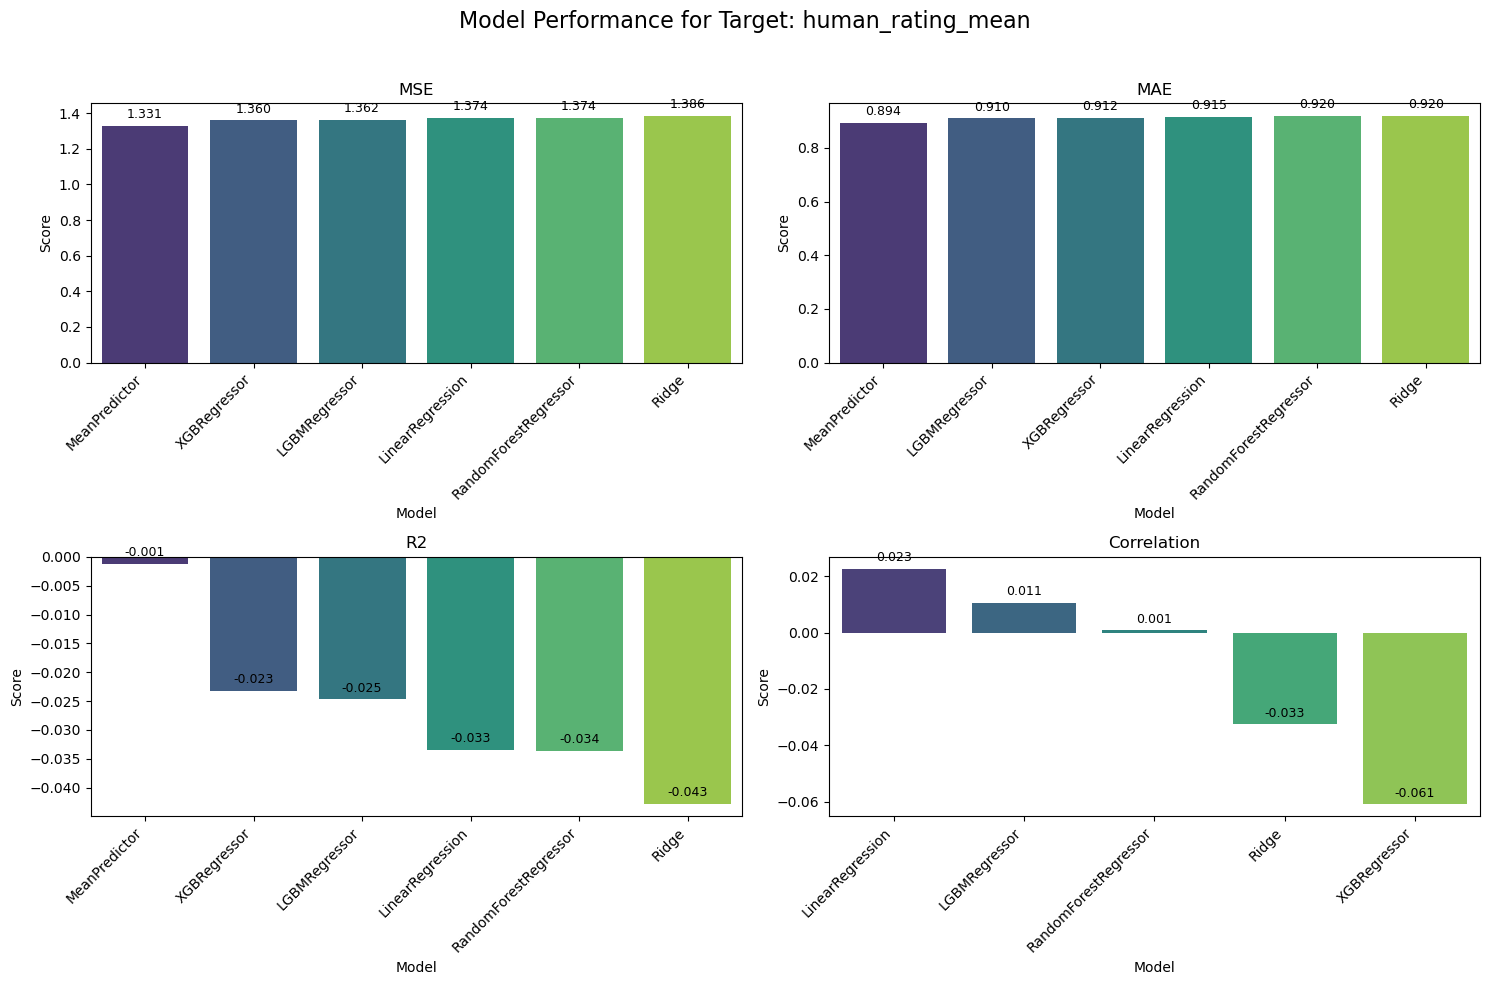

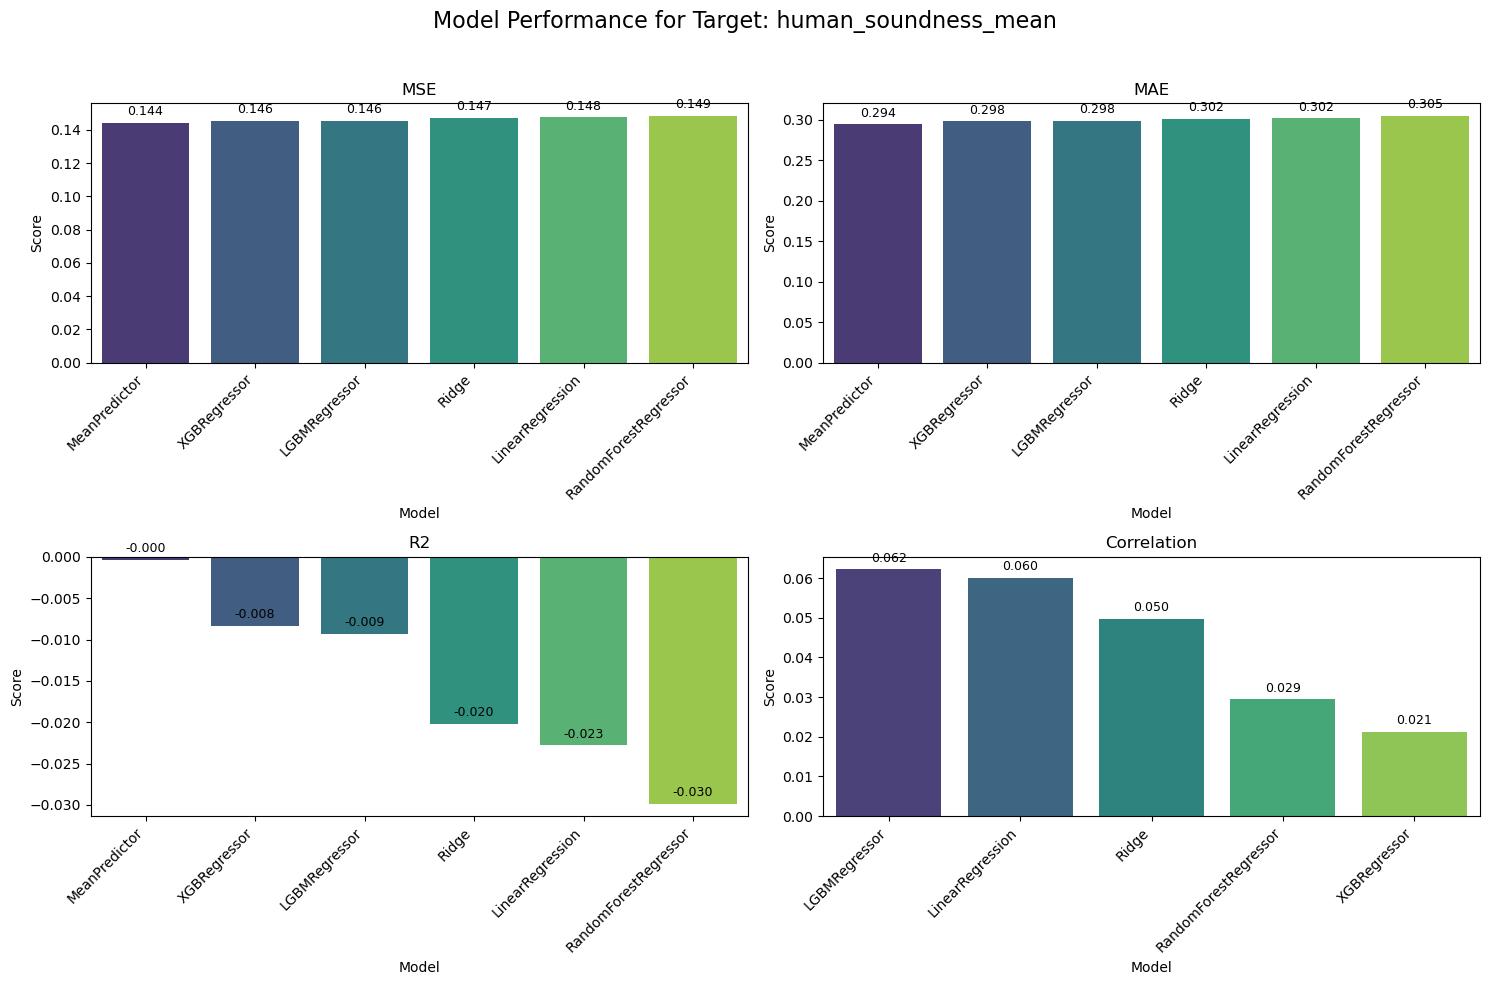

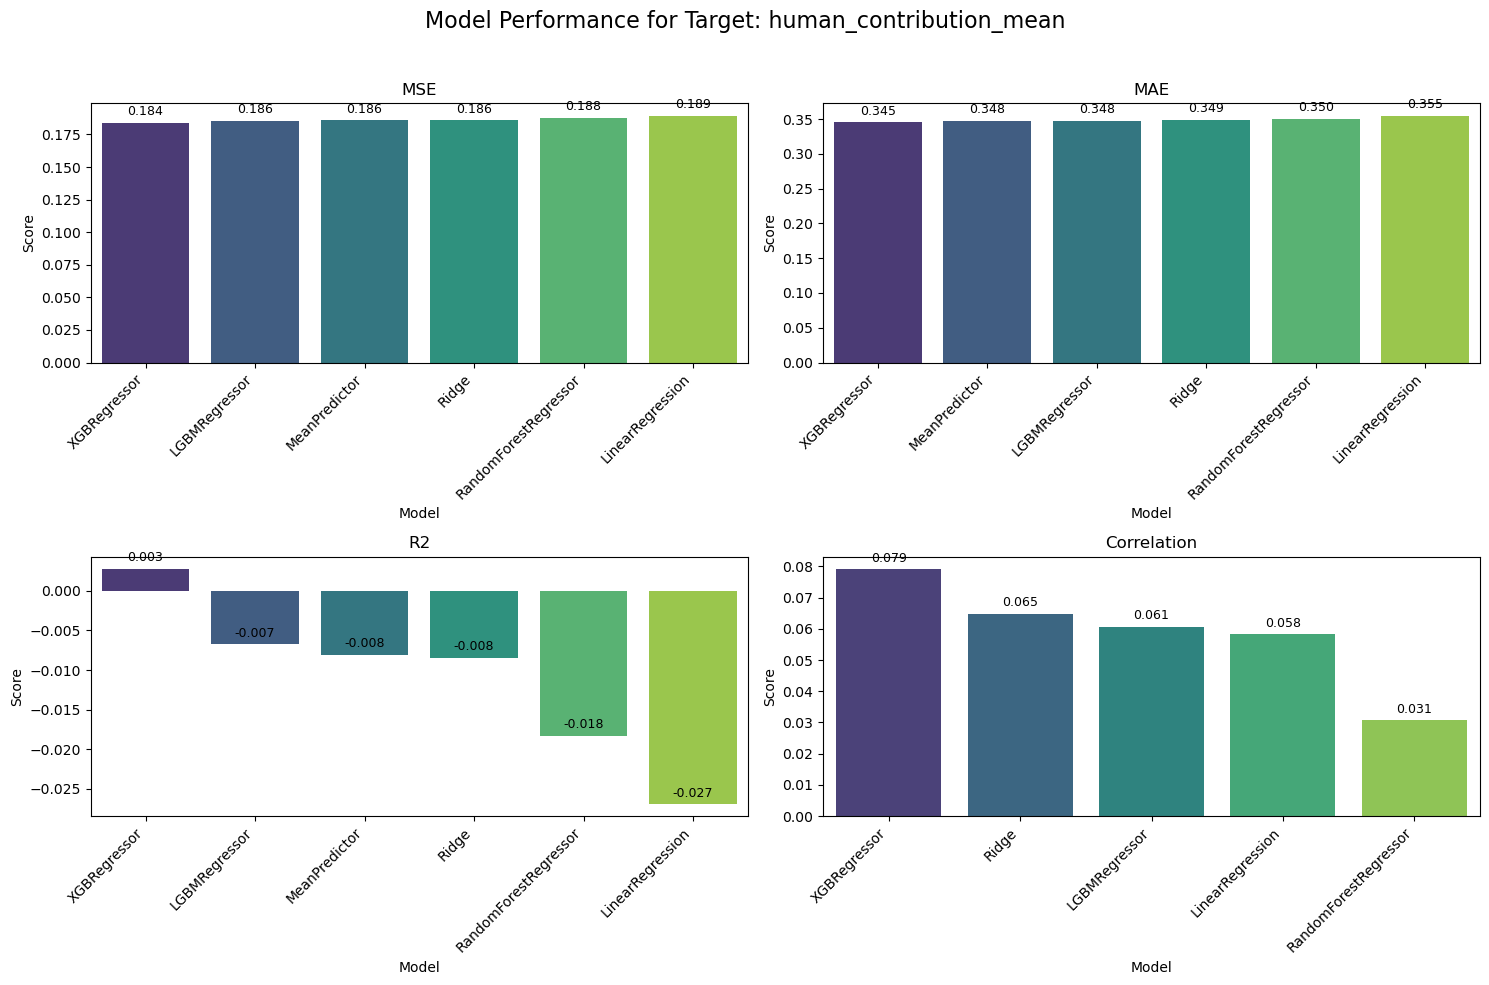

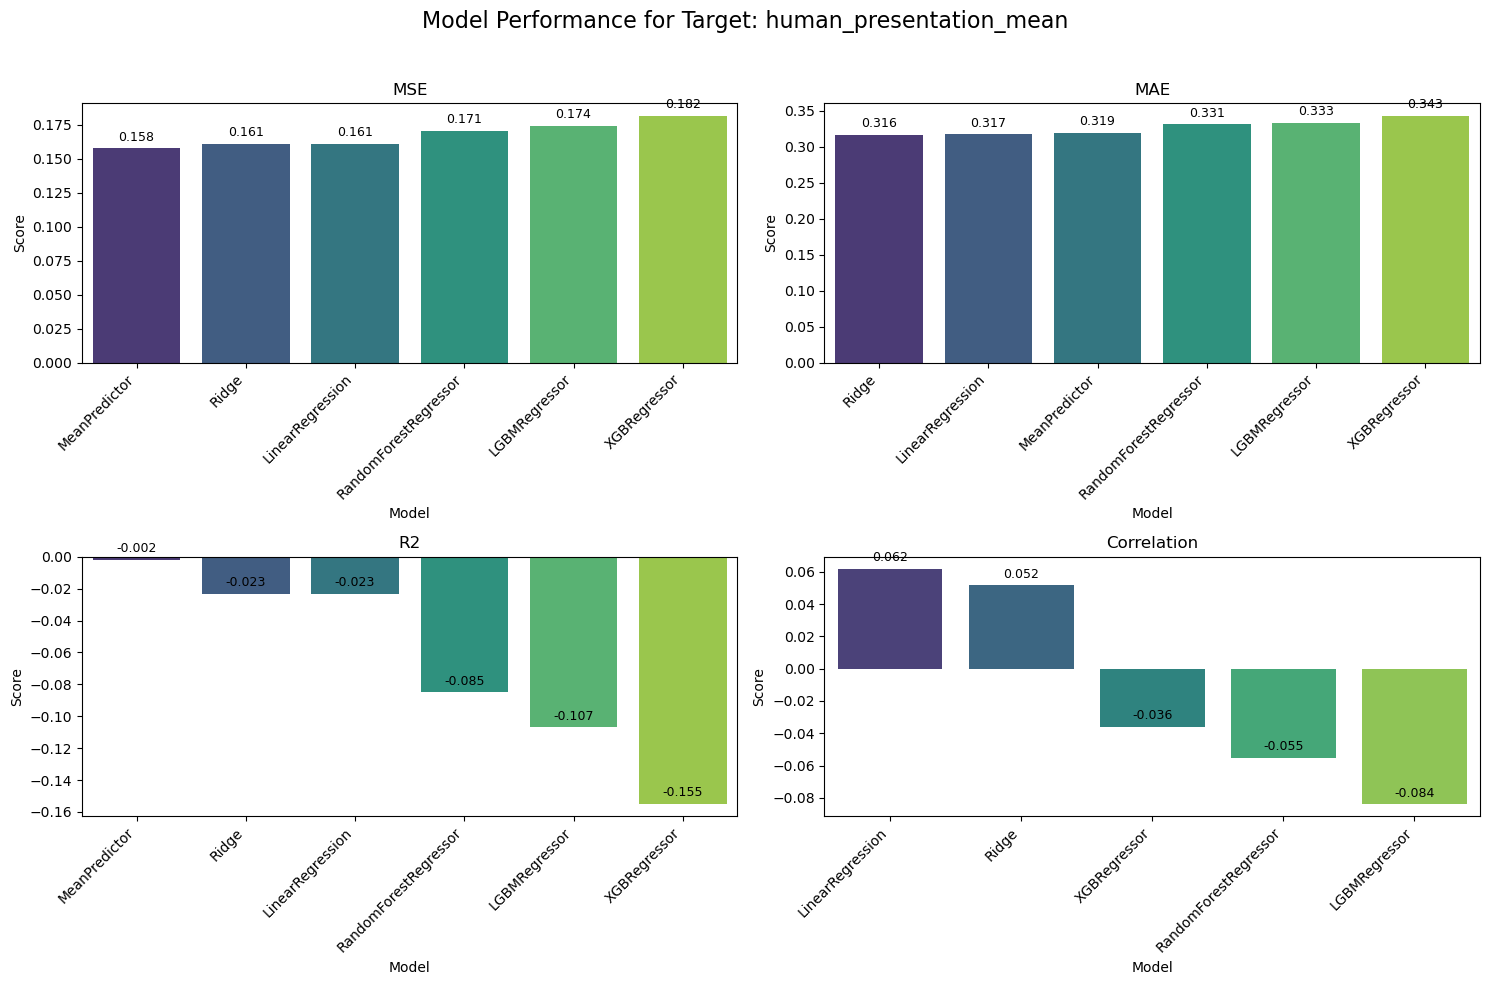

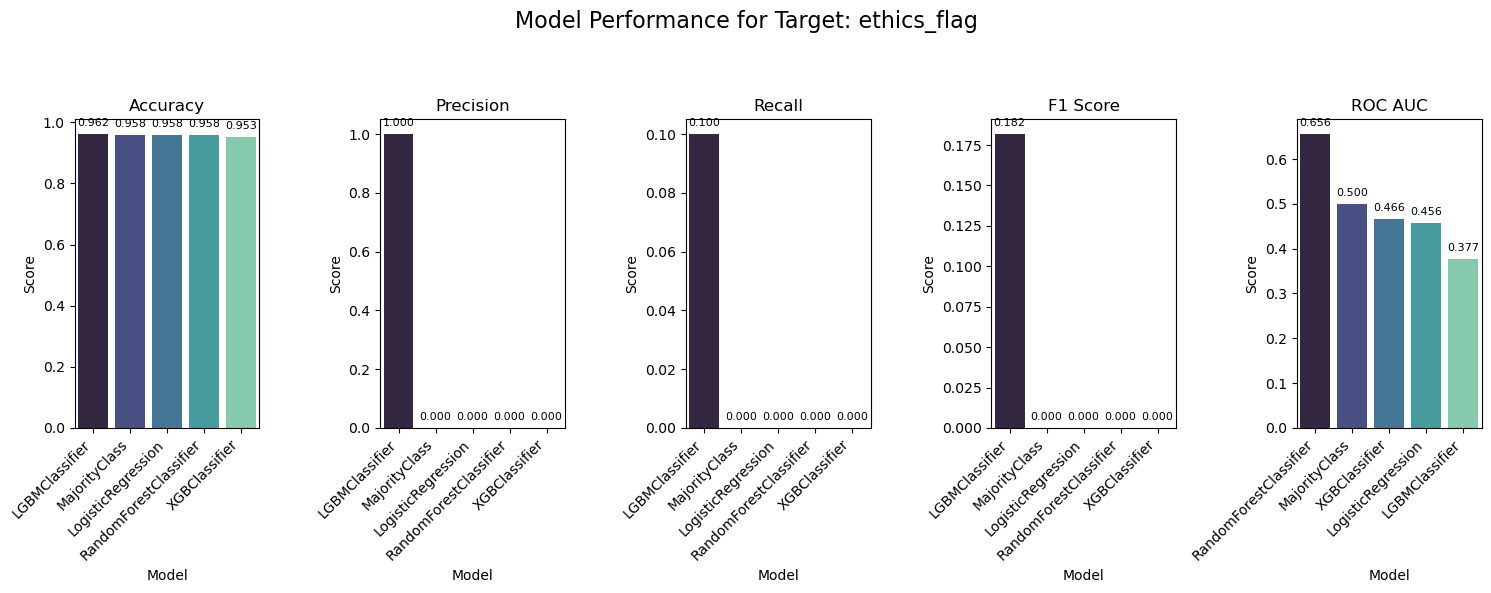

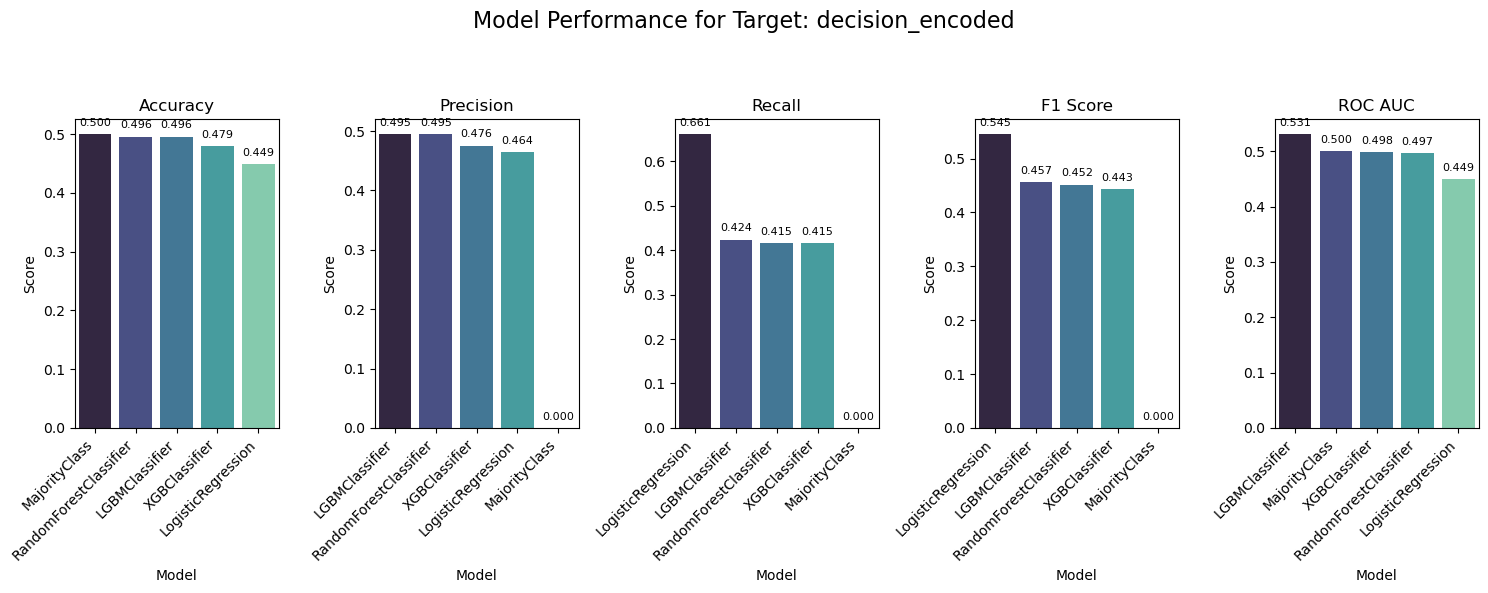

In [8]:
if results: 
    # Plotting for Regression Targets
    for target_name, model_metrics in results.items():
        # Identify if it's a classification target based on its name (ethics or decision)
        if target_name == target_col_ethics or target_name == target_col_decision_encoded: 
            continue # Skip classification targets here, handle them in the next block
        
        df_metrics = pd.DataFrame(model_metrics).T 
        
        expected_reg_metrics = ["MSE", "MAE", "R2", "Correlation"]
        for metric in expected_reg_metrics:
            if metric not in df_metrics.columns:
                df_metrics[metric] = np.nan
        df_metrics = df_metrics[expected_reg_metrics] 

        if df_metrics.empty:
            print(f"No metrics to plot for regression target: {target_name}")
            continue

        plt.figure(figsize=(15, 10))
        plt.suptitle(f"Model Performance for Target: {target_name}", fontsize=16)
        
        metrics_to_plot_reg = ["MSE", "MAE", "R2", "Correlation"]
        for i, metric in enumerate(metrics_to_plot_reg):
            plt.subplot(2, 2, i + 1)
            sorted_df = df_metrics[metric].dropna().sort_values(ascending=(metric in ["MSE", "MAE"]))
            
            if not sorted_df.empty:
                bars = sns.barplot(x=sorted_df.index, y=sorted_df.values, palette="viridis")
                plt.title(metric)
                plt.ylabel("Score")
                plt.xlabel("Model")
                plt.xticks(rotation=45, ha="right")
                for bar in bars.patches:
                    bars.annotate(format(bar.get_height(), '.3f'),
                                   (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',
                                   size=9, xytext=(0, 8),
                                   textcoords='offset points')
            else:
                plt.title(f"{metric} (No data)")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # Plotting for Classification Targets (ethics_flag and decision_encoded)
    classification_targets_to_plot = [target_col_ethics, target_col_decision_encoded]
    for clf_target_name in classification_targets_to_plot:
        if clf_target_name in results:
            clf_metrics_data = results[clf_target_name]
            df_clf_metrics = pd.DataFrame(clf_metrics_data).T
            
            expected_clf_metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
            for metric in expected_clf_metrics:
                if metric not in df_clf_metrics.columns:
                    df_clf_metrics[metric] = np.nan
            df_clf_metrics = df_clf_metrics[expected_clf_metrics]

            if not df_clf_metrics.empty:
                plt.figure(figsize=(15, 6)) 
                plt.suptitle(f"Model Performance for Target: {clf_target_name}", fontsize=16)
                
                metrics_to_plot_clf = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
                num_clf_metrics = len(metrics_to_plot_clf)
                
                for i, metric in enumerate(metrics_to_plot_clf):
                    plt.subplot(1, num_clf_metrics, i + 1) 
                    sorted_df_clf = df_clf_metrics[metric].dropna().sort_values(ascending=False) 
                    
                    if not sorted_df_clf.empty:
                        bars_clf = sns.barplot(x=sorted_df_clf.index, y=sorted_df_clf.values, palette="mako")
                        plt.title(metric)
                        plt.ylabel("Score")
                        plt.xlabel("Model")
                        plt.xticks(rotation=45, ha="right")
                        for bar in bars_clf.patches:
                            bars_clf.annotate(format(bar.get_height(), '.3f') if not np.isnan(bar.get_height()) else 'N/A',
                                           (bar.get_x() + bar.get_width() / 2,
                                            bar.get_height()), ha='center', va='center',
                                           size=8, xytext=(0, 8),
                                           textcoords='offset points')
                    else:
                        plt.title(f"{metric} (No data)")
                plt.tight_layout(rect=[0, 0, 1, 0.92])
                plt.show()
            else:
                print(f"No metrics to plot for classification target: {clf_target_name}")
        else:
            print(f"No results found for classification target: {clf_target_name}")
else:
    print("No results to plot.")


## Feature Importance Plotting

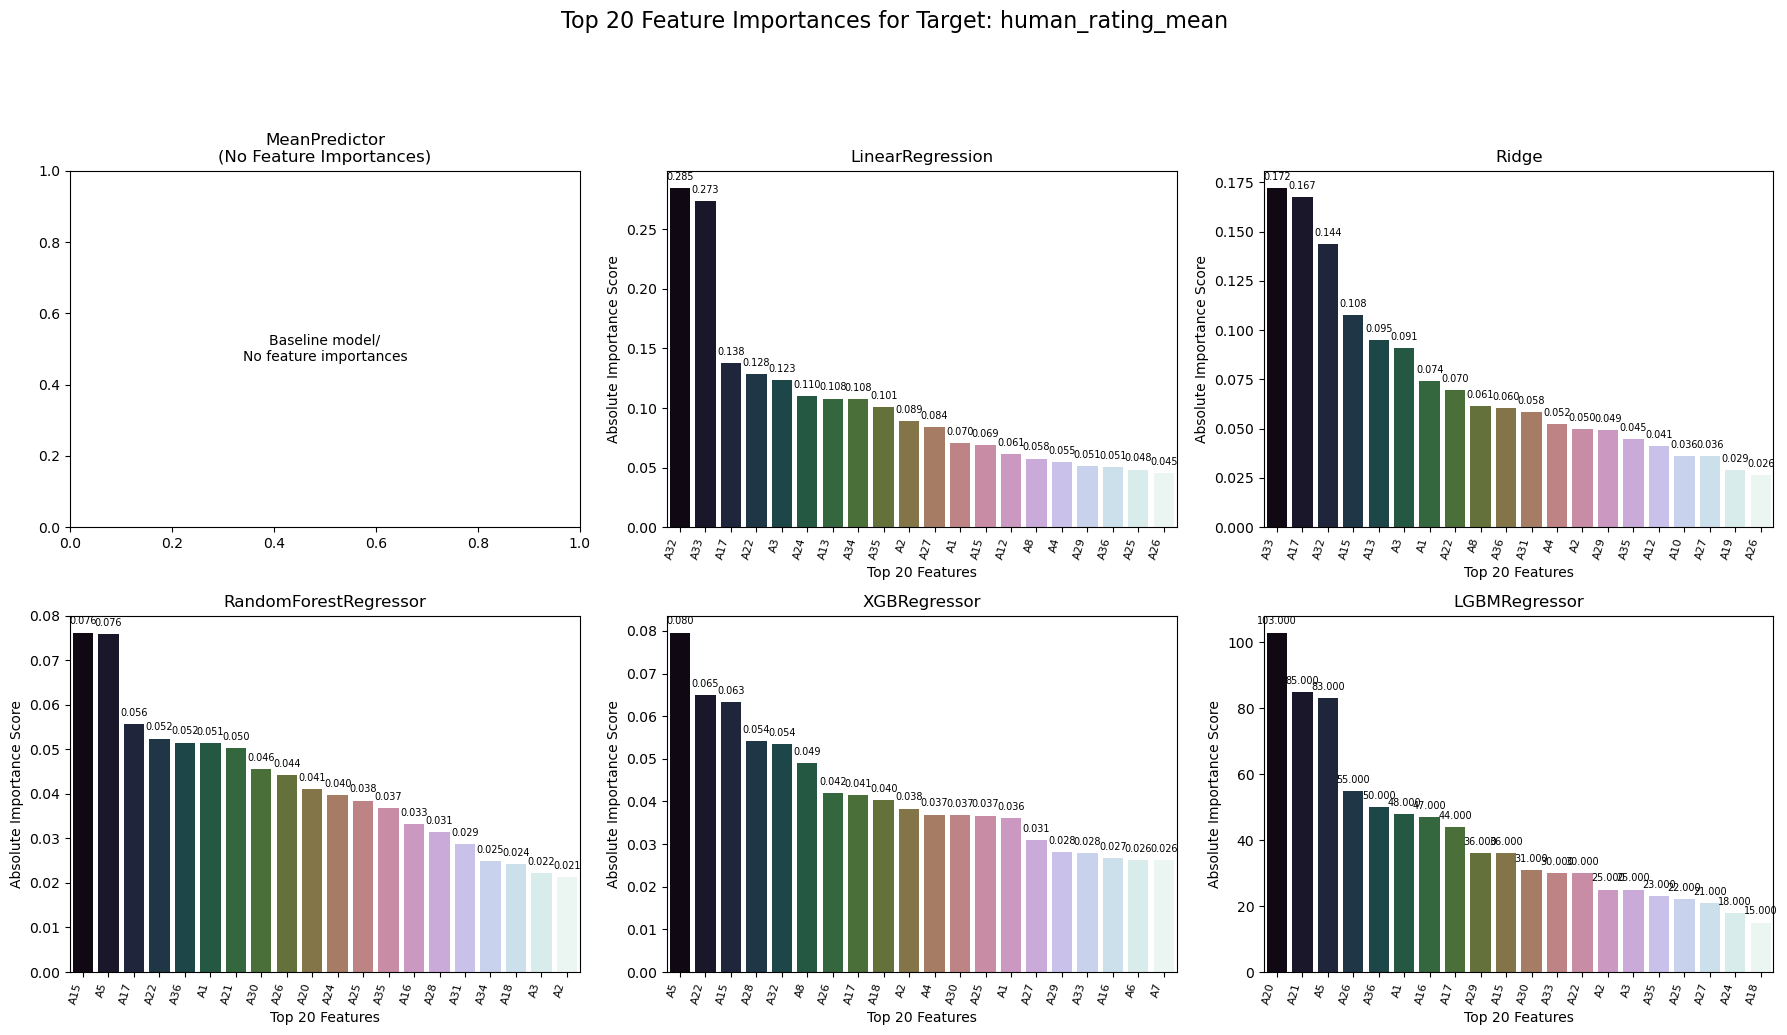

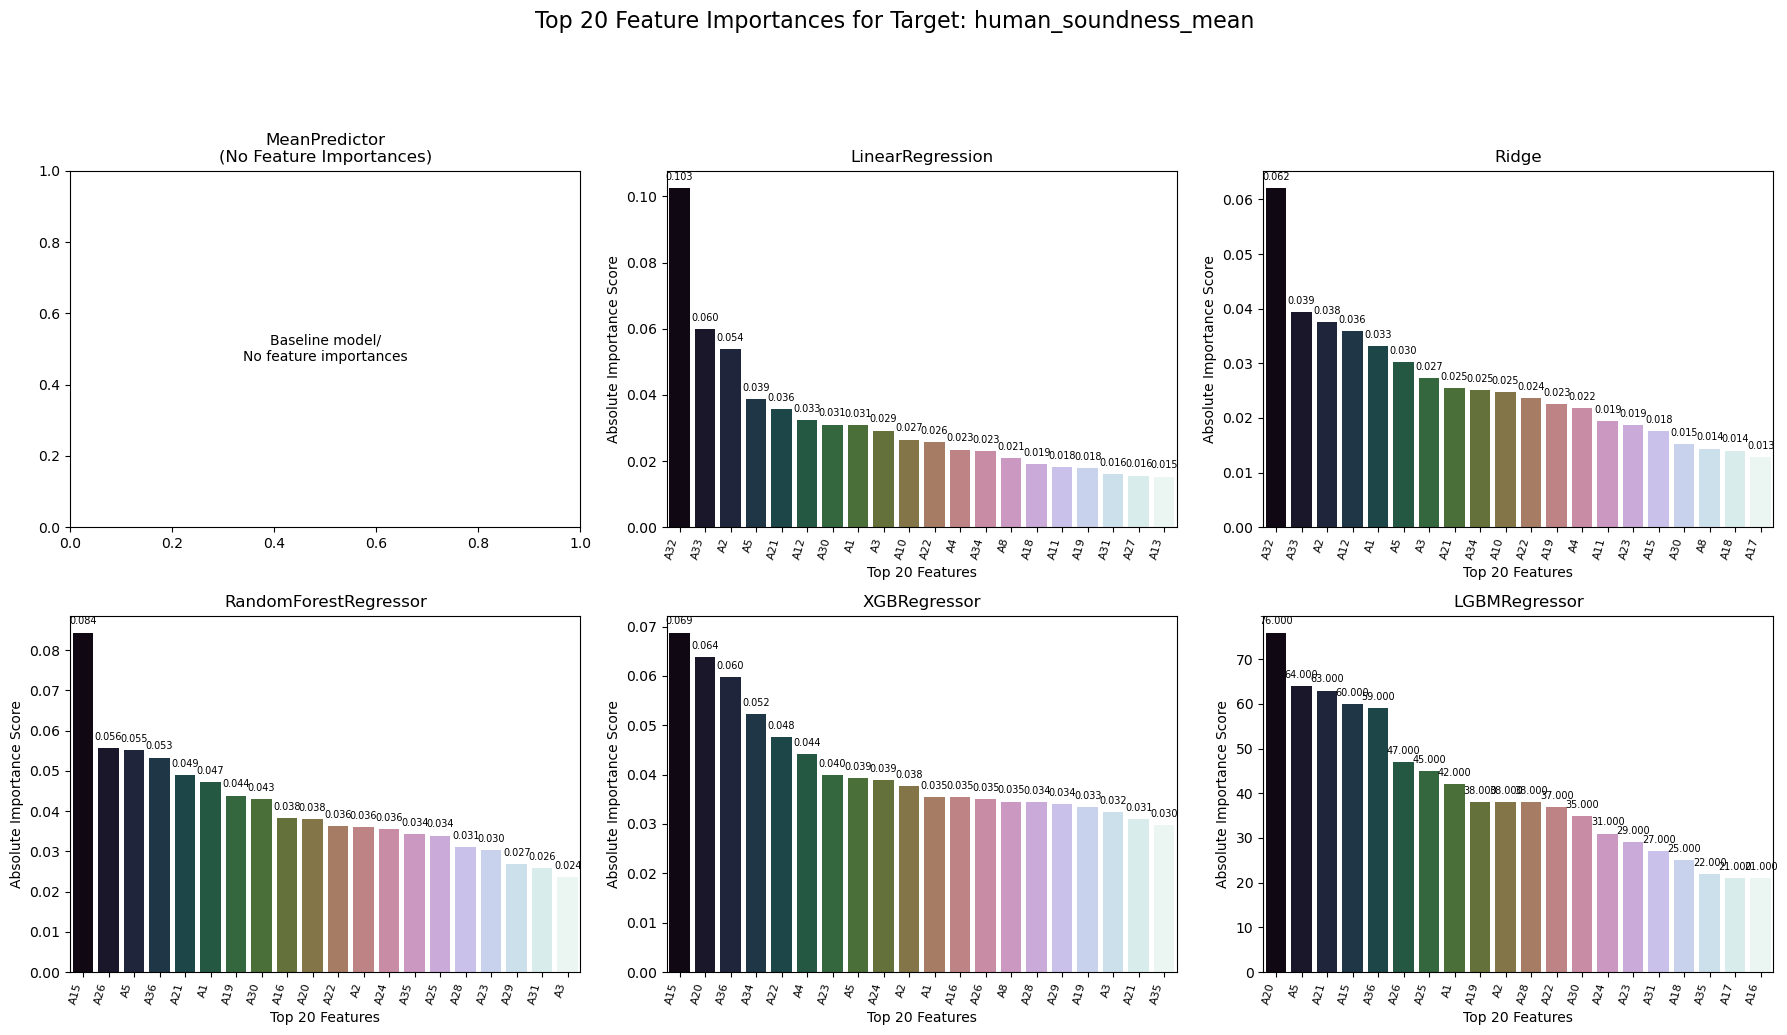

In [ ]:
# FEATURE_NAMES_FOR_PLOTTING is now ALL_FEATURE_ITEM_IDS from Cell 1
if feature_importances_results and not X_train.empty: 
    num_total_features = X_train.shape[1] # Should be len(ALL_FEATURE_ITEM_IDS)
    
    for target_name, model_importances_dict in feature_importances_results.items():
        if not model_importances_dict: 
            print(f"No feature importances recorded for target: {target_name}")
            continue

        num_models = len(model_importances_dict)
        if num_models == 0:
            continue

        cols_subplot = int(np.ceil(np.sqrt(num_models)))
        rows_subplot = int(np.ceil(num_models / cols_subplot))
        
        plt.figure(figsize=(6 * cols_subplot, 5 * rows_subplot)) 
        plt.suptitle(f"Top 20 Feature Importances for Target: {target_name}", fontsize=16, y=1.03)

        model_idx = 0
        for model_name, importances_array in model_importances_dict.items():
            model_idx += 1 # Increment subplot index here
            plt.subplot(rows_subplot, cols_subplot, model_idx)

            if importances_array is None:
                print(f"Importances are None for {model_name} on target {target_name}.")
                plt.title(f"{model_name}\n(No Importances)")
                plt.text(0.5, 0.5, "No importances available", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                continue
            
            # For baseline models, importances are all zeros.
            if model_name in ["MeanPredictor", "MajorityClass"] or np.all(importances_array == 0):
                plt.title(f"{model_name}\n(No Feature Importances)")
                plt.text(0.5, 0.5, "Baseline model/\nNo feature importances", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                # No further plotting for these
                continue

            if isinstance(importances_array, np.ndarray) and importances_array.ndim > 1:
                plot_importances_flat = np.abs(importances_array).mean(axis=0) if importances_array.shape[0] > 1 else np.abs(importances_array.flatten())
            else:
                plot_importances_flat = np.abs(np.array(importances_array).flatten())


            if len(plot_importances_flat) != num_total_features:
                print(f"Skipping feature importance for {model_name} on target {target_name} due to mismatched importances length. Expected {num_total_features}, got {len(plot_importances_flat)}.")
                plt.title(f"{model_name}\n(Importance Length Error)")
                plt.text(0.5, 0.5, "Importance length error", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                continue
            
            current_feature_names = FEATURE_NAMES_FOR_PLOTTING
            if len(plot_importances_flat) != len(FEATURE_NAMES_FOR_PLOTTING):
                current_feature_names = X_train.columns 
                print(f"Warning: Mismatch between plot_importances_flat length ({len(plot_importances_flat)}) and FEATURE_NAMES_FOR_PLOTTING length ({len(FEATURE_NAMES_FOR_PLOTTING)}) for {model_name} on {target_name}. Using X_train.columns.")
                if len(plot_importances_flat) != len(current_feature_names):
                    print(f"Critical Error: Mismatch even with X_train.columns for {model_name}. Skipping plot.")
                    plt.title(f"{model_name}\n(Critical Import. Error)")
                    continue 
            
            importance_series = pd.Series(plot_importances_flat, index=current_feature_names)
            top_n = 20
            # Filter out zero importances before sorting and taking top N, unless all are zero
            non_zero_importances = importance_series[importance_series != 0]
            if not non_zero_importances.empty:
                 sorted_importances = non_zero_importances.sort_values(ascending=False).head(top_n)
            elif not importance_series.empty: # All importances are zero
                 sorted_importances = importance_series.sort_values(ascending=False).head(top_n) # Show zeros if that's all
            else: # Empty series
                sorted_importances = pd.Series()


            if not sorted_importances.empty:
                bars = sns.barplot(x=sorted_importances.index, y=sorted_importances.values, palette="cubehelix")
                plt.title(f"{model_name}")
                plt.ylabel("Absolute Importance Score")
                plt.xlabel(f"Top {min(top_n, len(sorted_importances))} Features")
                plt.xticks(rotation=75, ha="right", fontsize=8) 
                for bar in bars.patches:
                    bars.annotate(format(bar.get_height(), '.3f'),
                                   (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',
                                   size=7, xytext=(0, 8),
                                   textcoords='offset points')
            else: # Should be covered by the earlier checks for MeanPredictor/MajorityClass or all zeros
                plt.title(f"{model_name}\n(No Non-Zero Importances)")
                plt.text(0.5, 0.5, "No non-zero importances\nto display", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


        plt.tight_layout(rect=[0, 0, 1, 0.96]) 
        plt.show()
else:
    print("No feature importances to plot or X_train is empty.")


## Learning Curve Plotting


--- Generating Learning Curves (Using Best Params from Initial Tuning) ---

Learning Curves for Regression Target: human_rating_mean (Metric: R2 Score)
  Model: MeanPredictor


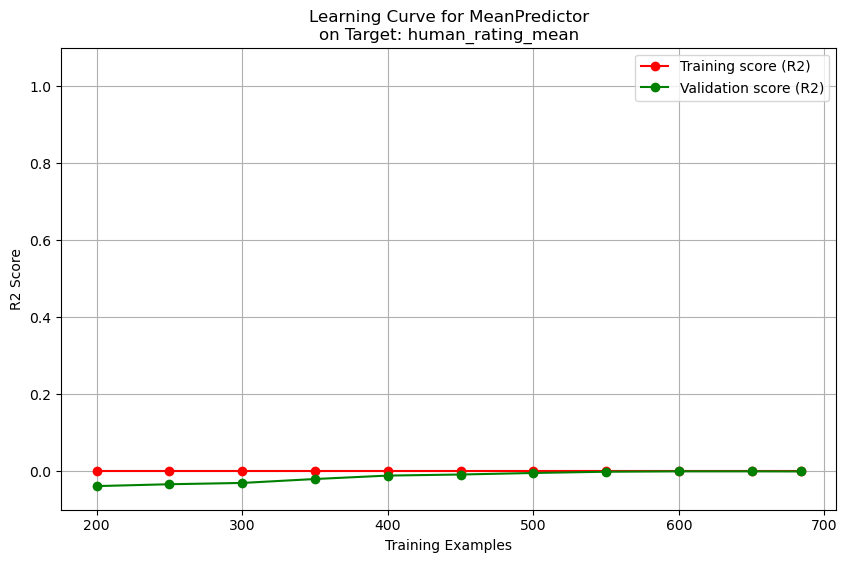

  Model: LinearRegression


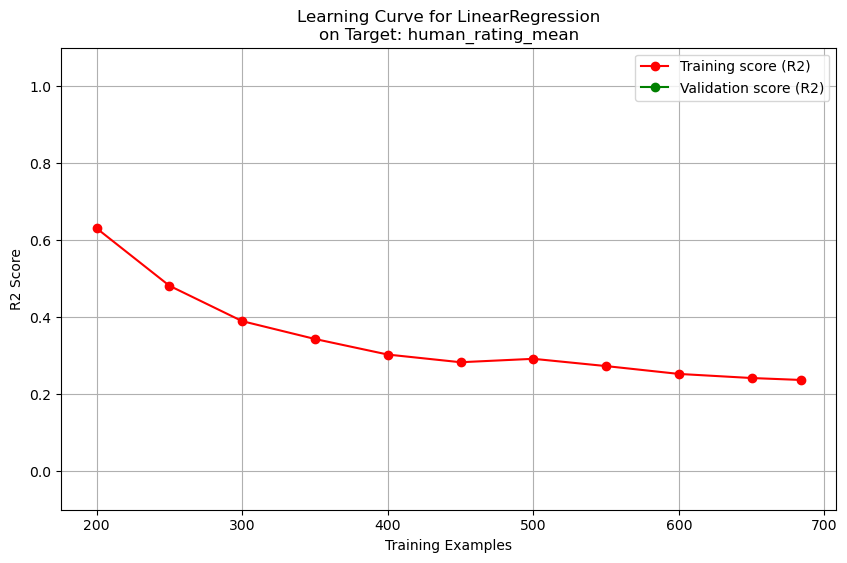

  Model: Ridge


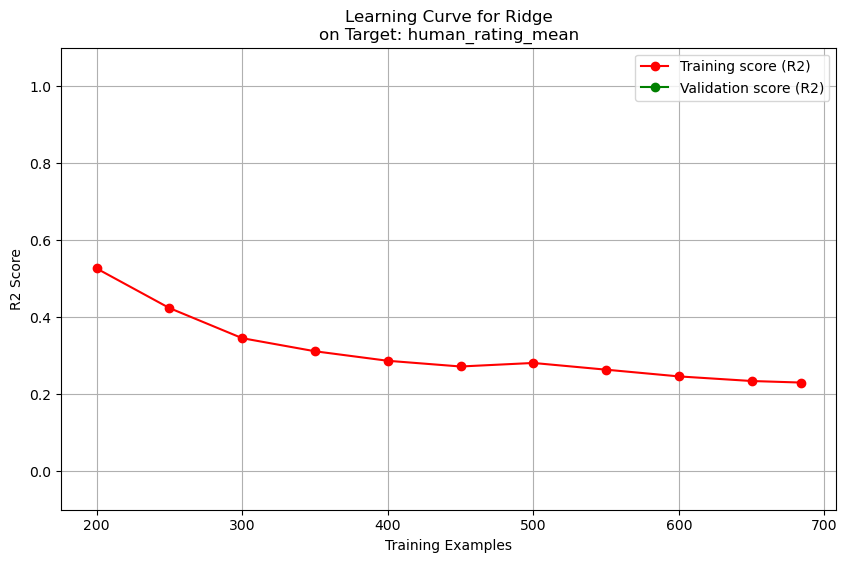

  Model: RandomForestRegressor


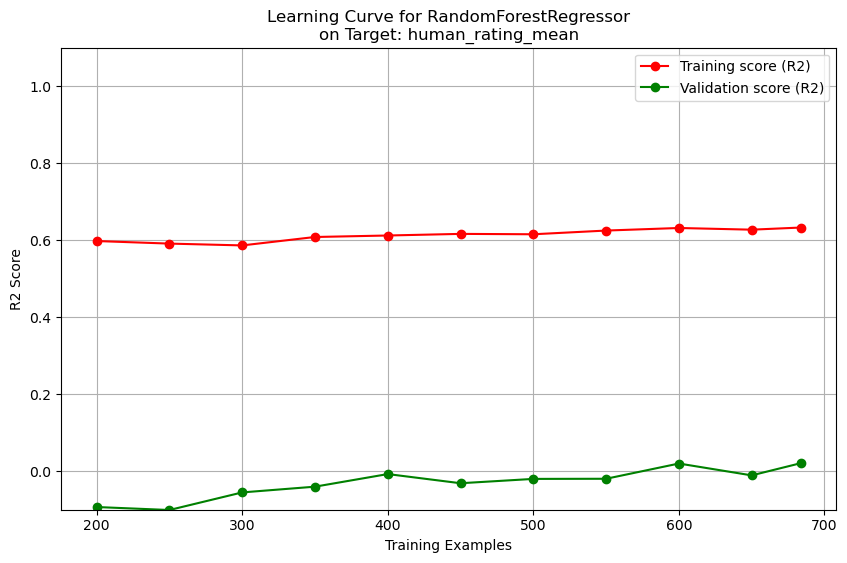

  Model: XGBRegressor


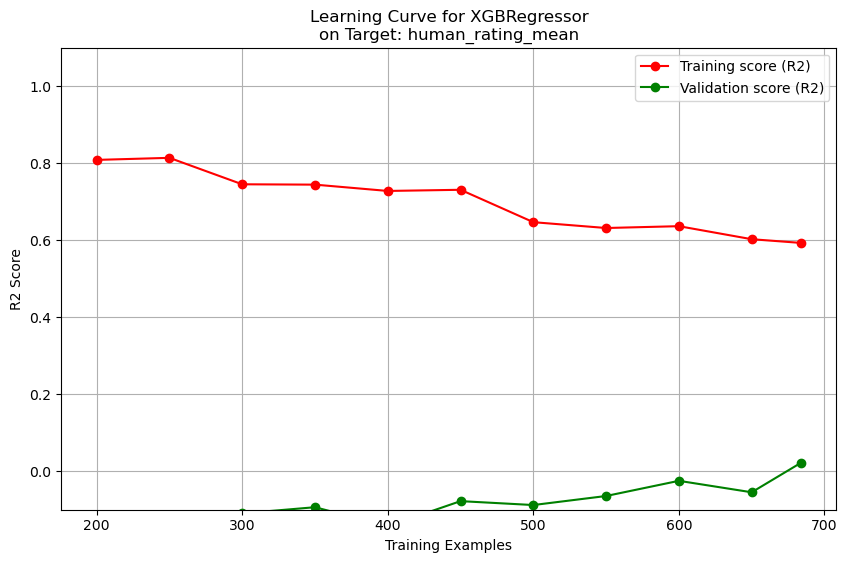

  Model: LGBMRegressor


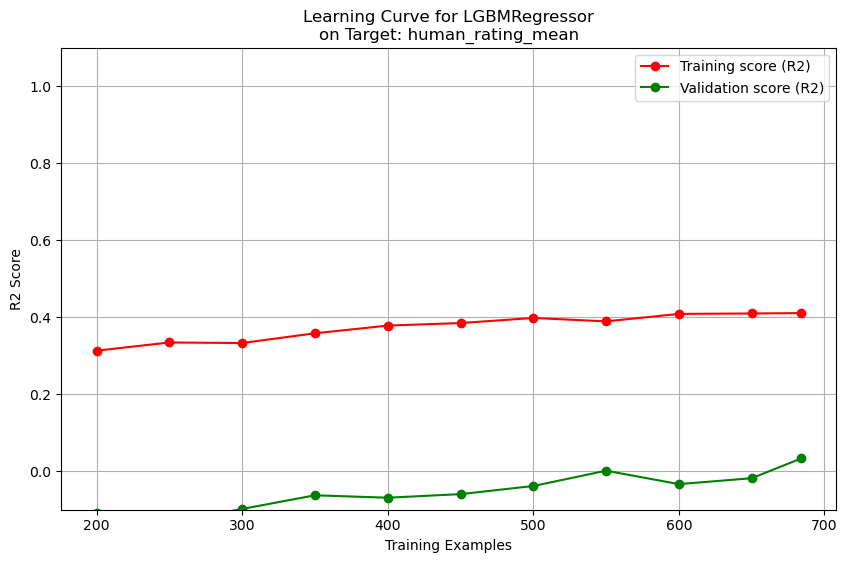


Learning Curves for Regression Target: human_soundness_mean (Metric: R2 Score)
  Model: MeanPredictor


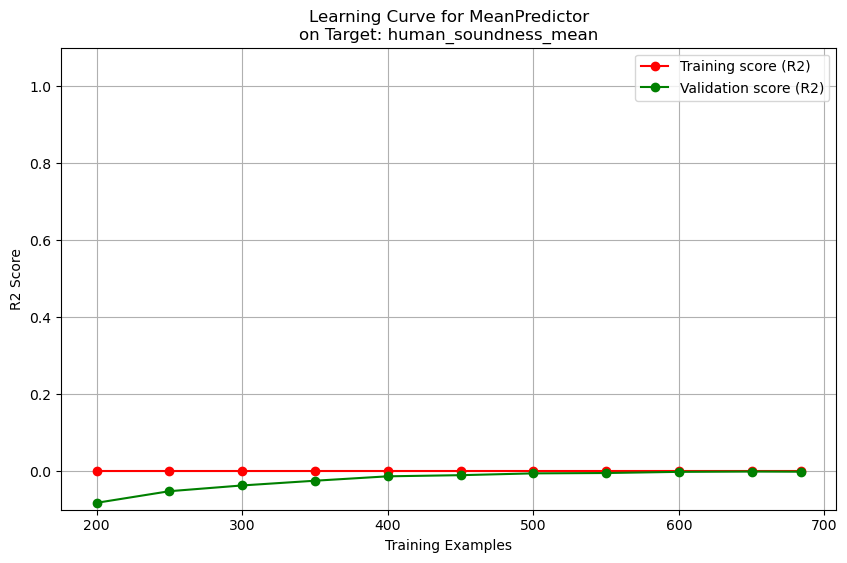

  Model: LinearRegression


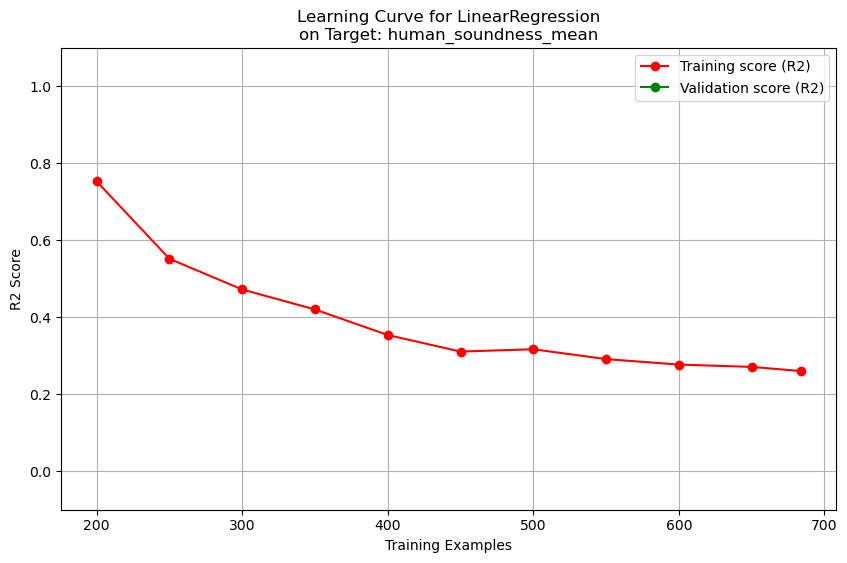

  Model: Ridge


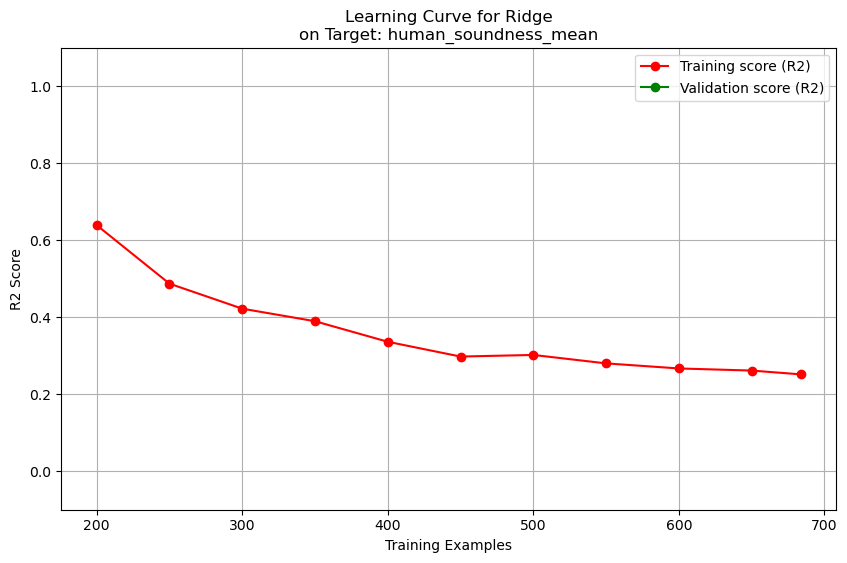

  Model: RandomForestRegressor


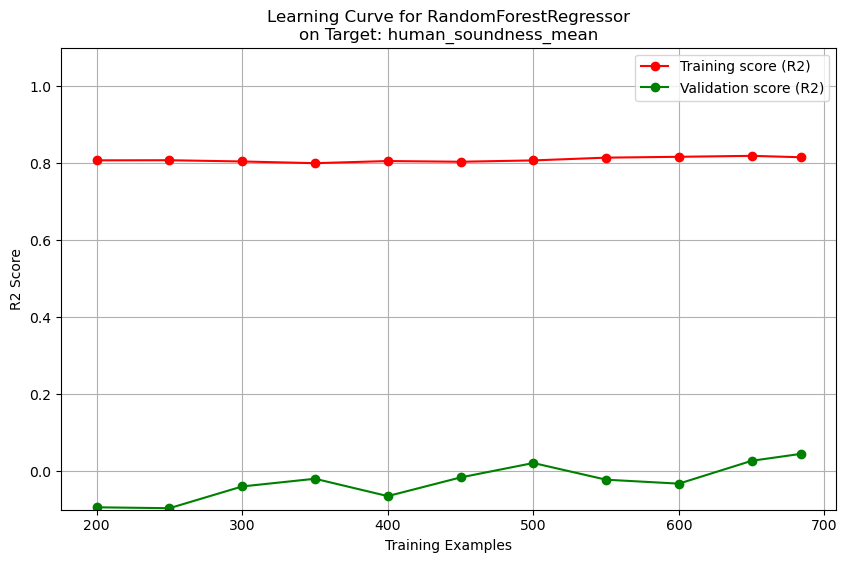

  Model: XGBRegressor


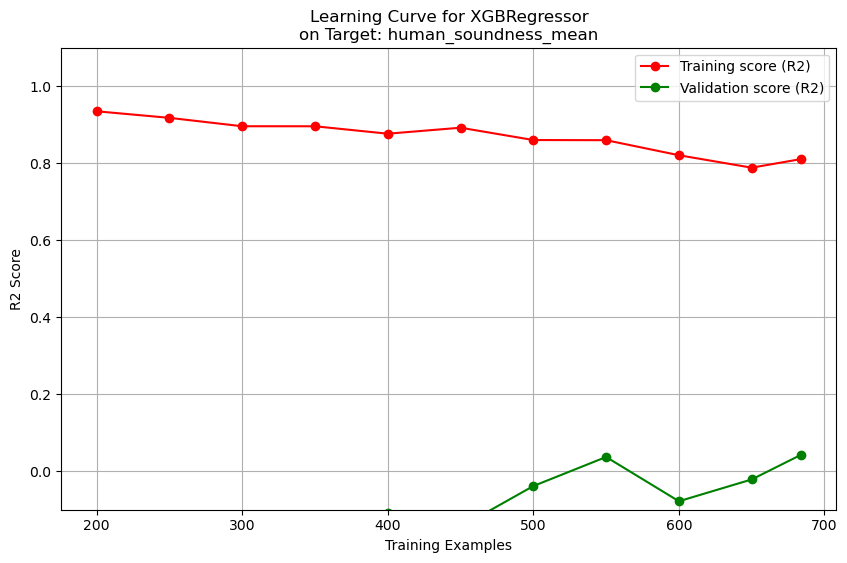

  Model: LGBMRegressor


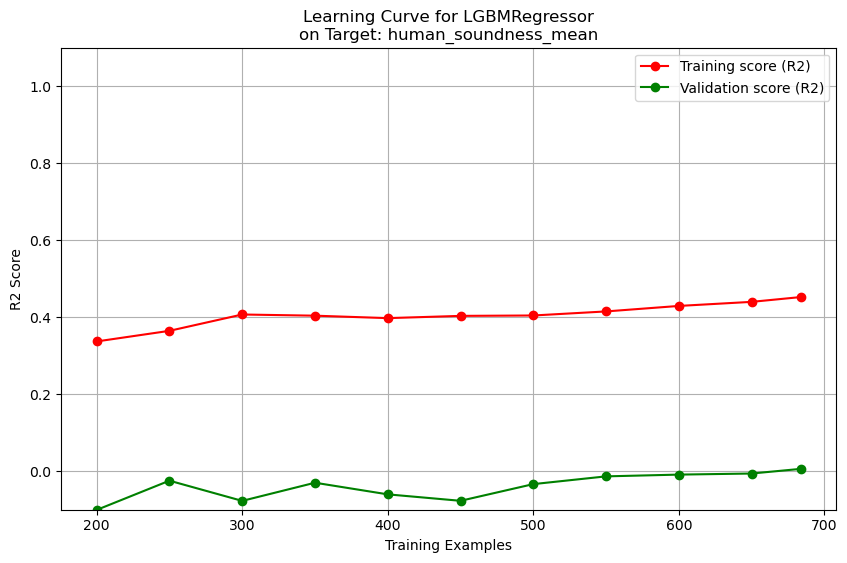


Learning Curves for Regression Target: human_contribution_mean (Metric: R2 Score)
  Model: MeanPredictor


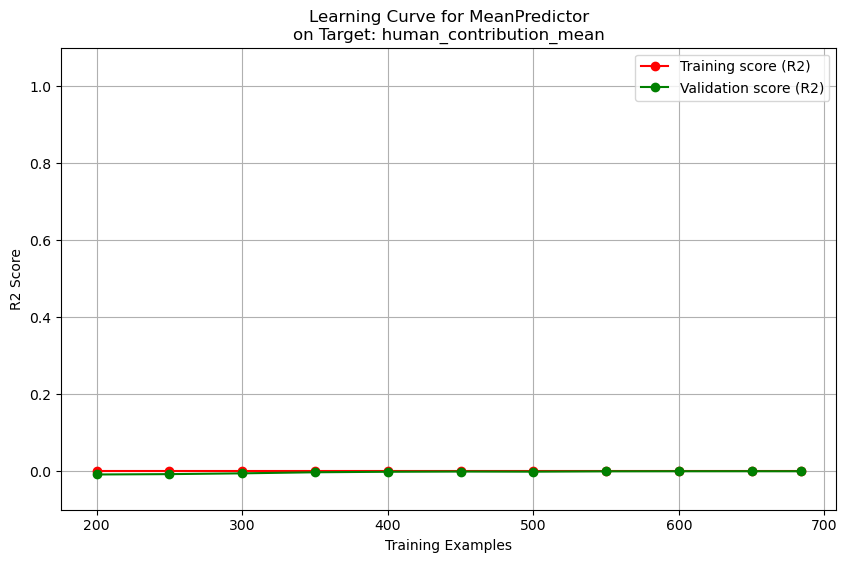

  Model: LinearRegression


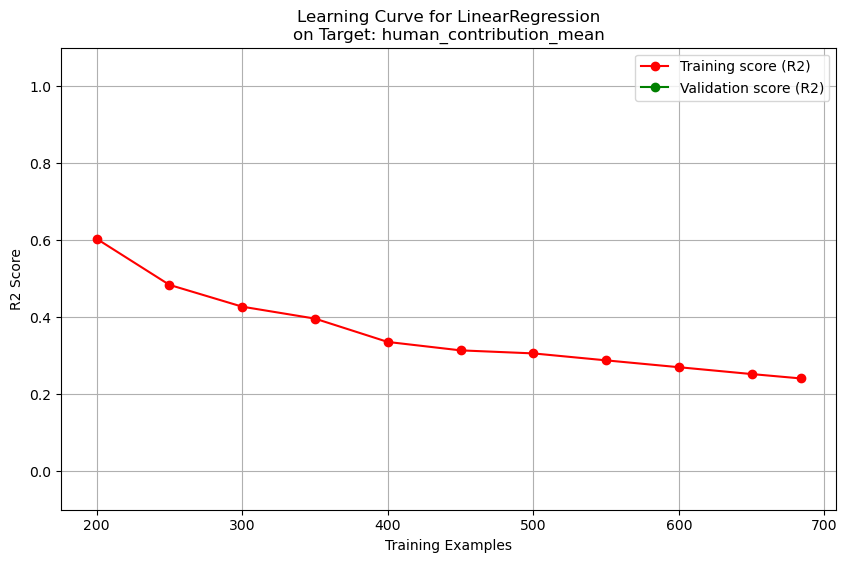

  Model: Ridge


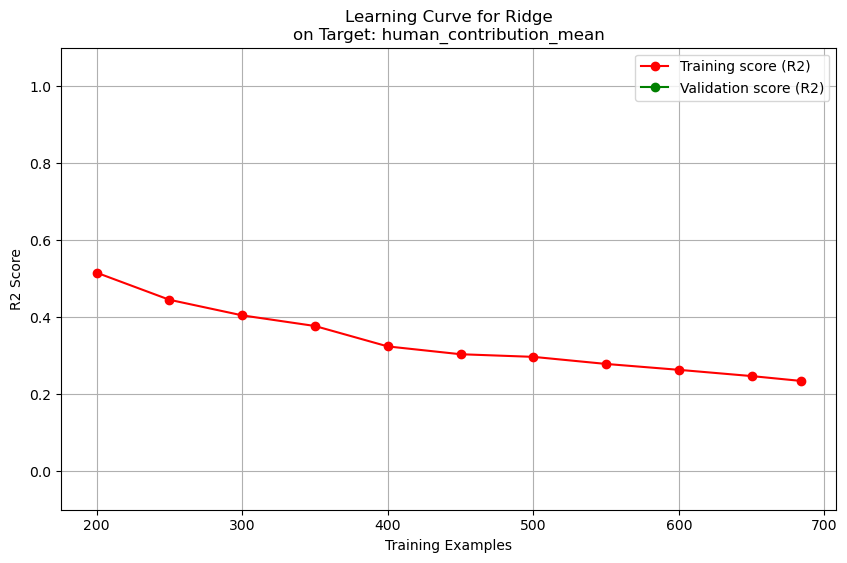

  Model: RandomForestRegressor


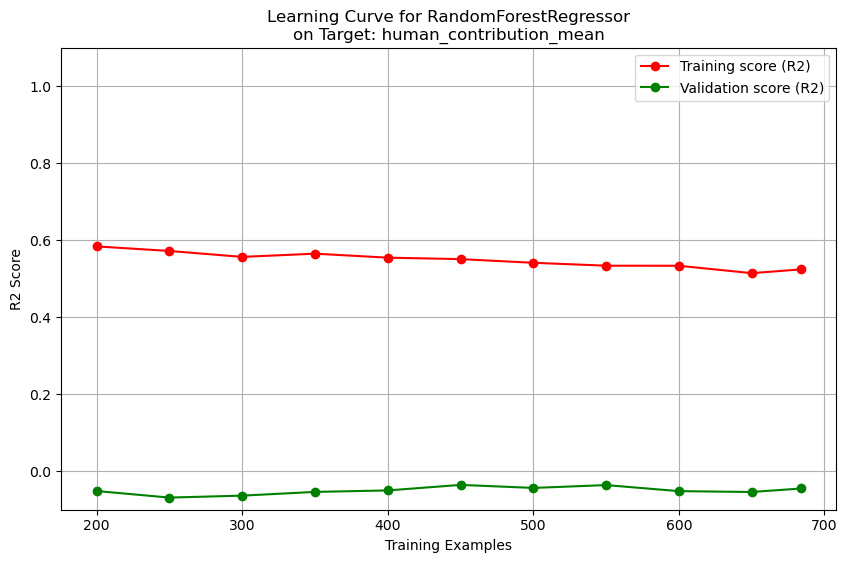

  Model: XGBRegressor


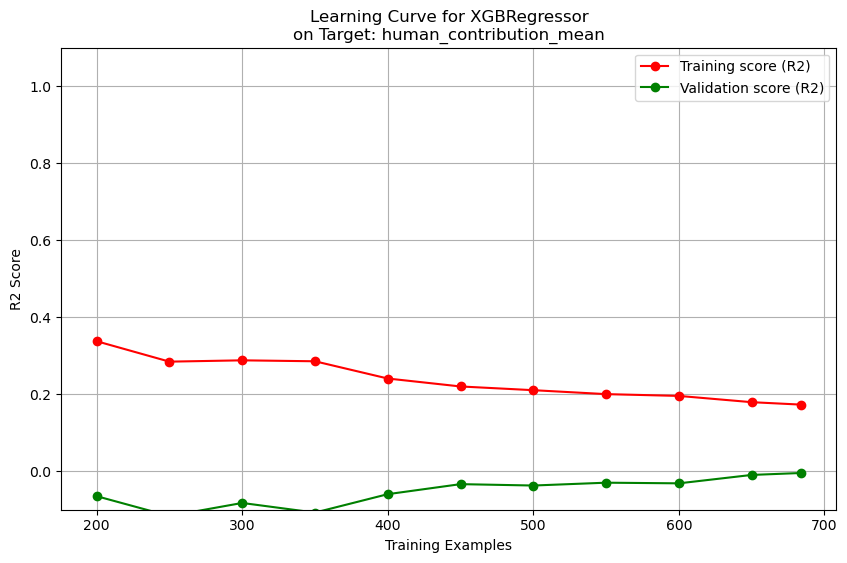

  Model: LGBMRegressor


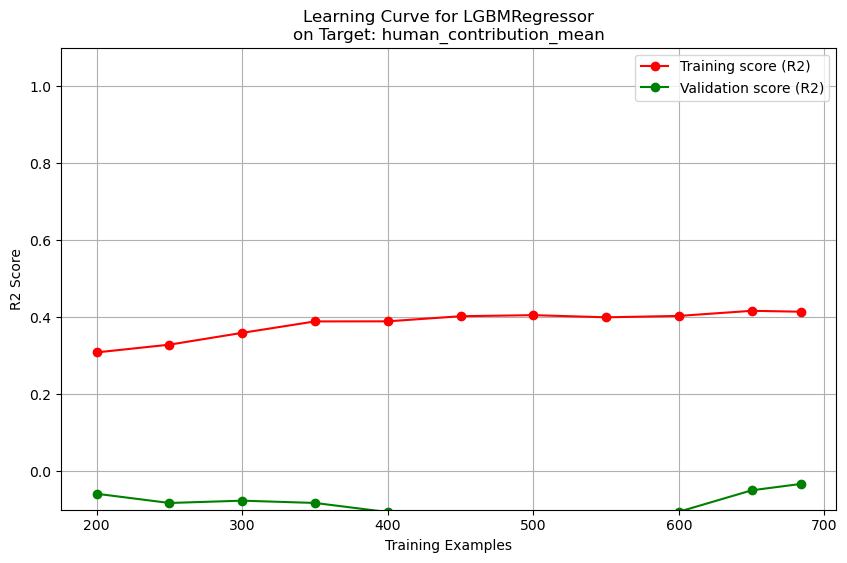


Learning Curves for Regression Target: human_presentation_mean (Metric: R2 Score)
  Model: MeanPredictor


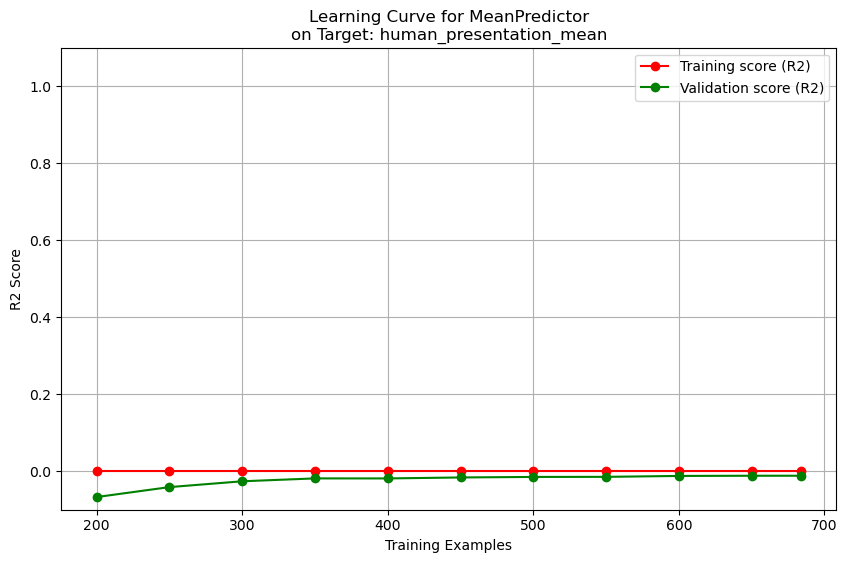

  Model: LinearRegression


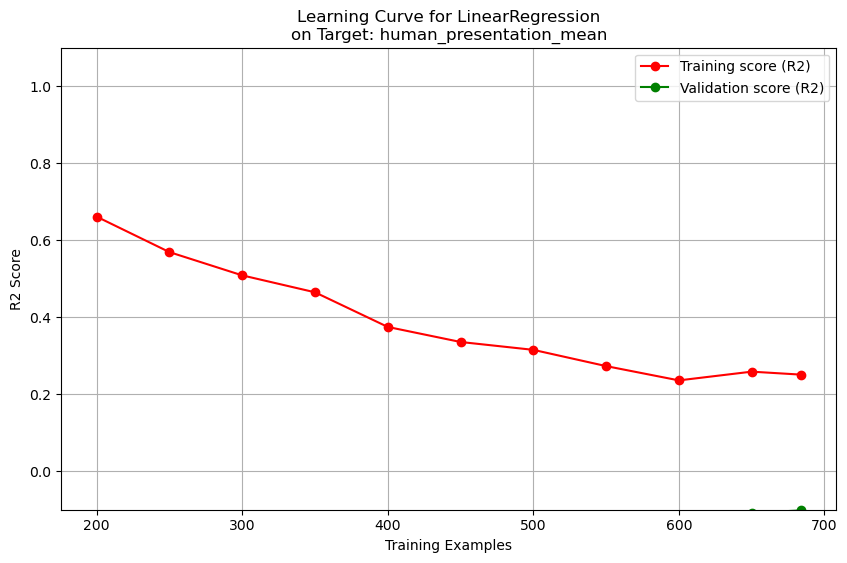

  Model: Ridge


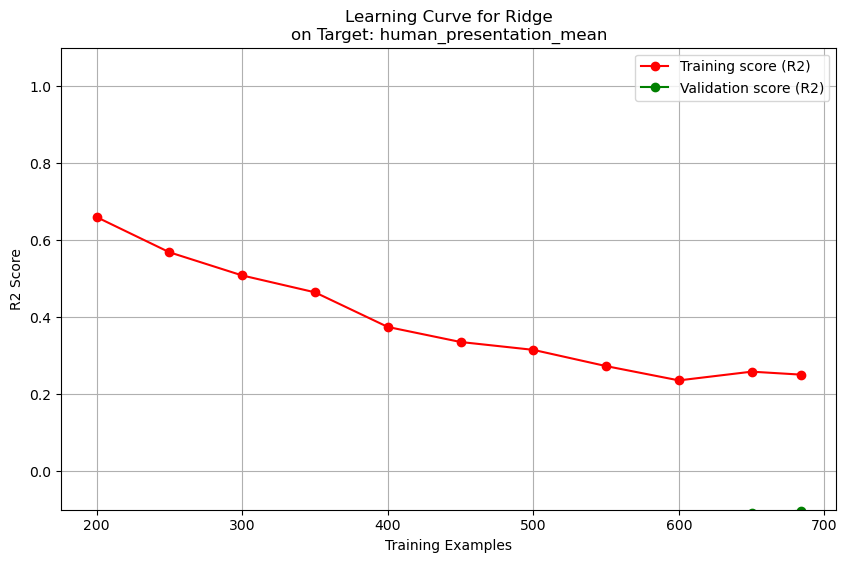

  Model: RandomForestRegressor


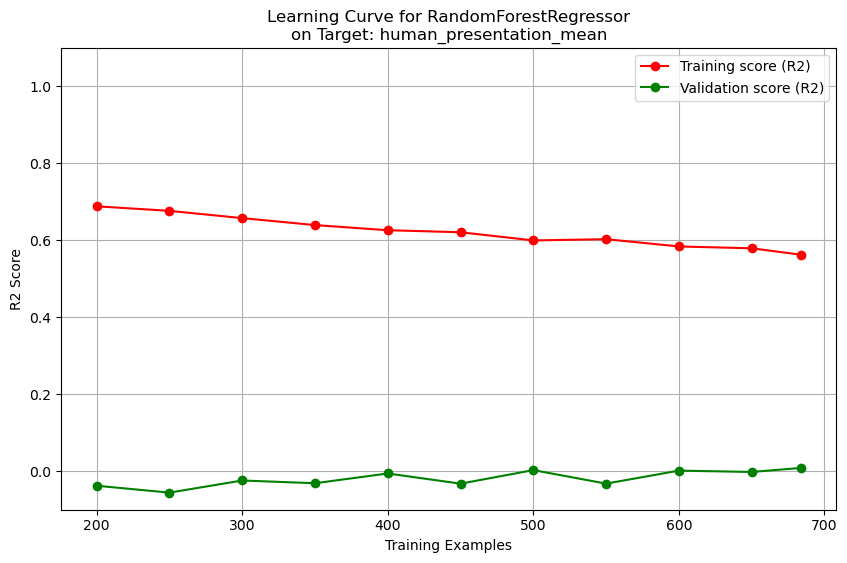

  Model: XGBRegressor


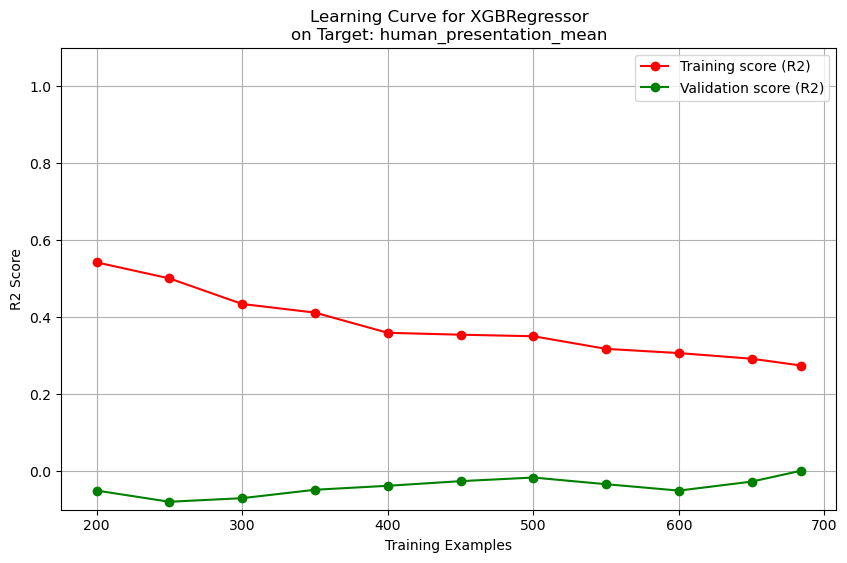

  Model: LGBMRegressor


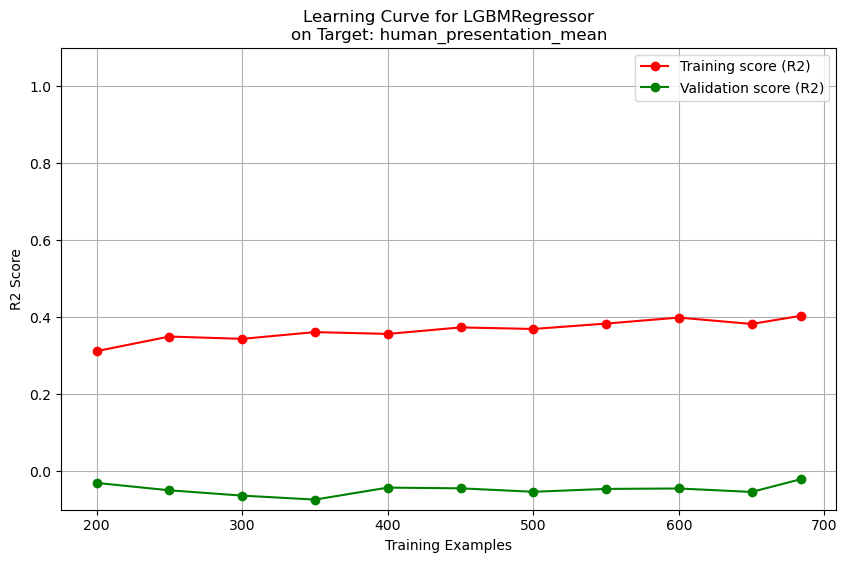


Learning Curves for Classification Target: ethics_flag (Metric: F1 Score)
  Model: MajorityClass


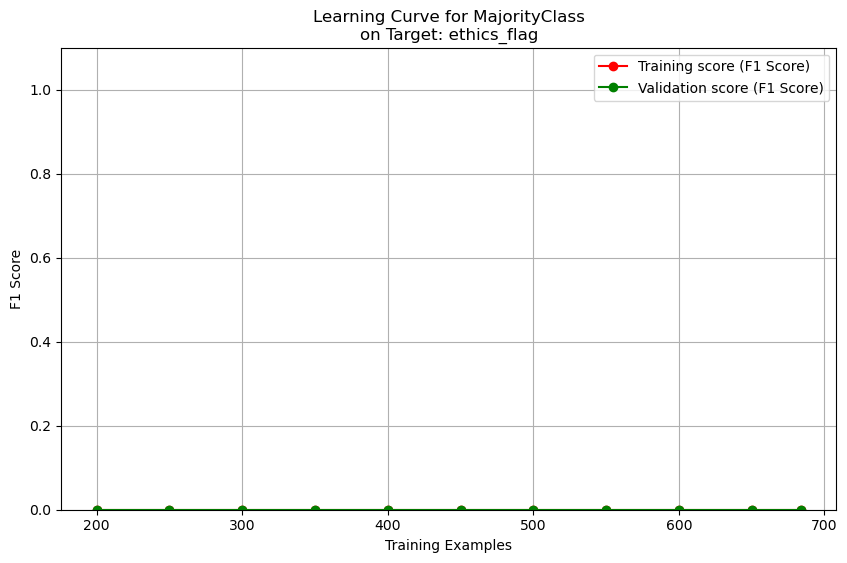

  Model: LogisticRegression


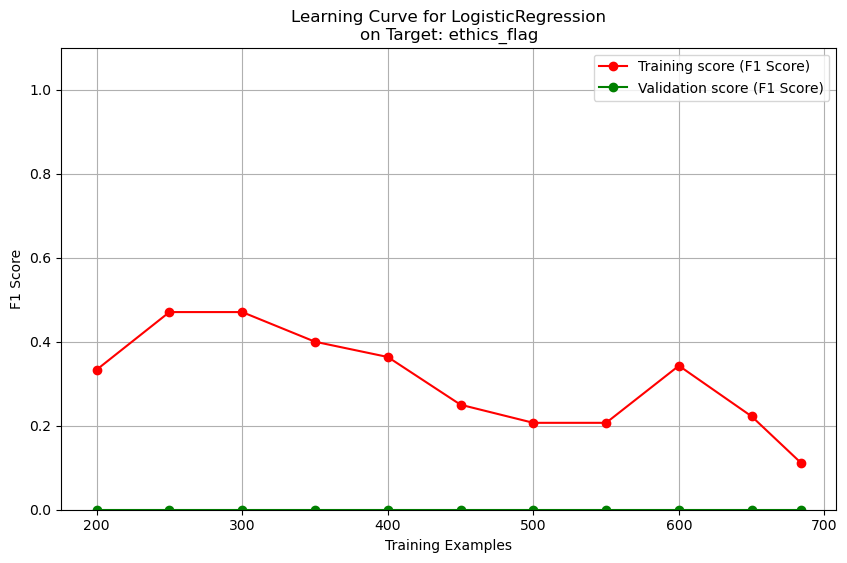

  Model: RandomForestClassifier


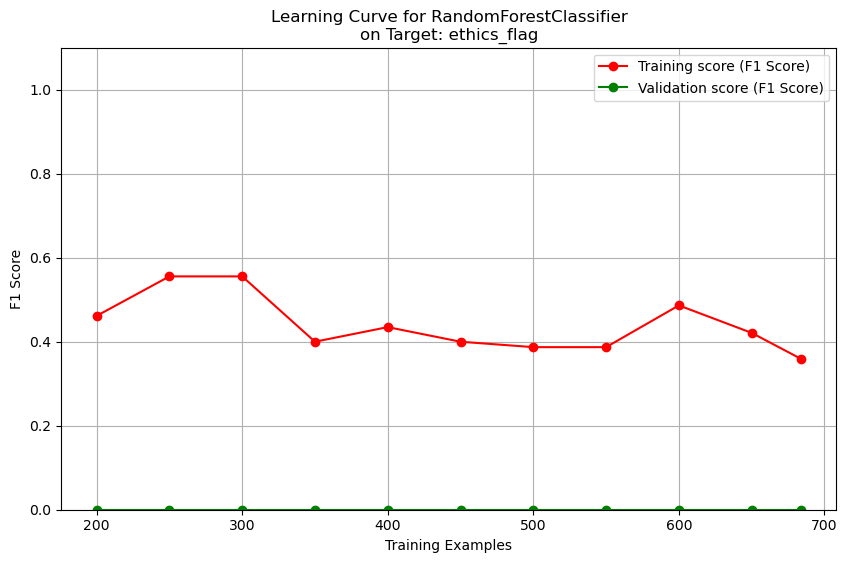

  Model: XGBClassifier


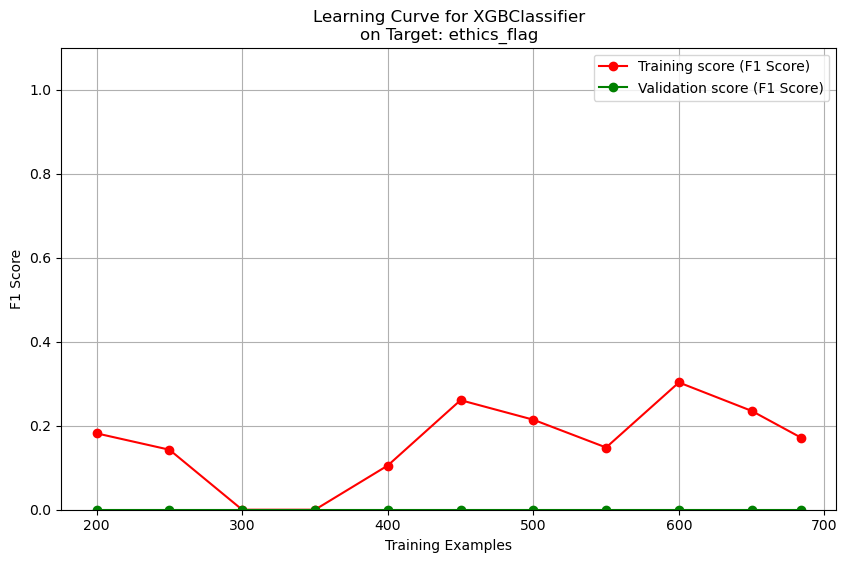

  Model: LGBMClassifier


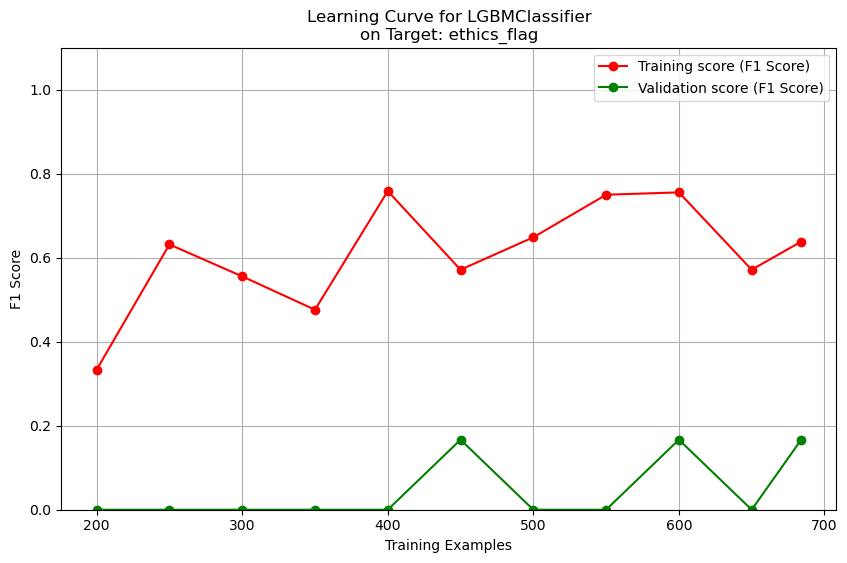


Learning Curves for Classification Target: decision_encoded (Metric: F1 Score)
  Model: MajorityClass


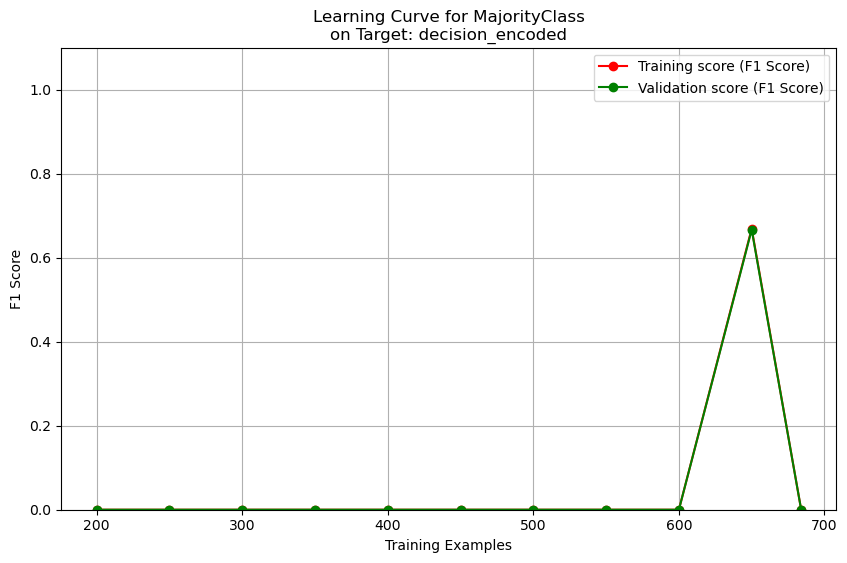

  Model: LogisticRegression


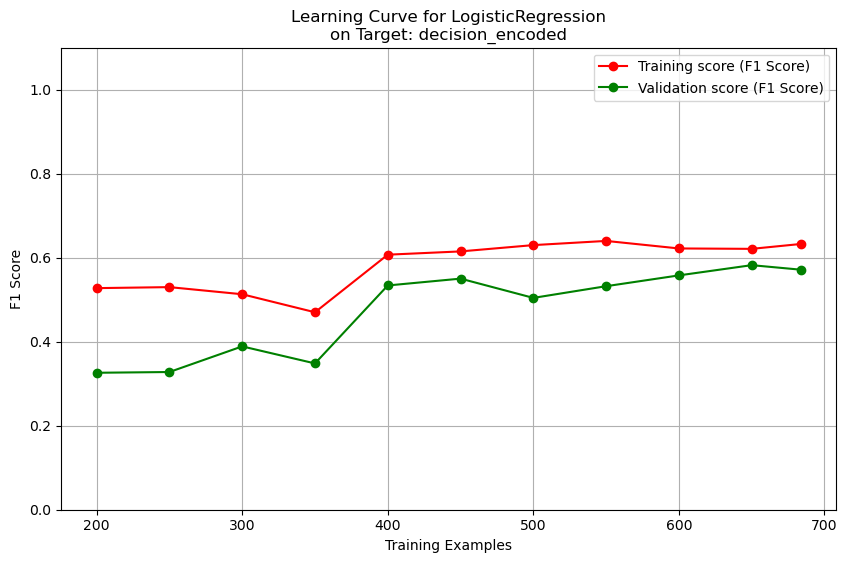

  Model: RandomForestClassifier


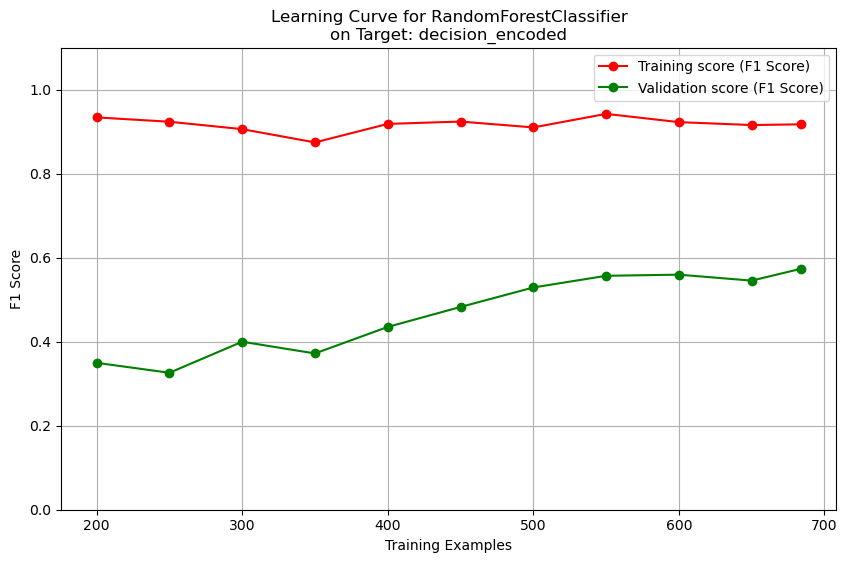

  Model: XGBClassifier


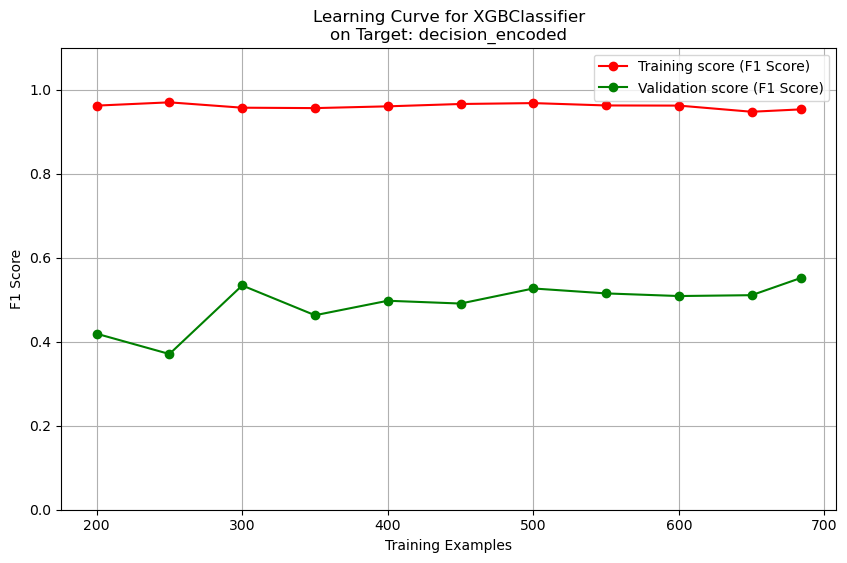

  Model: LGBMClassifier


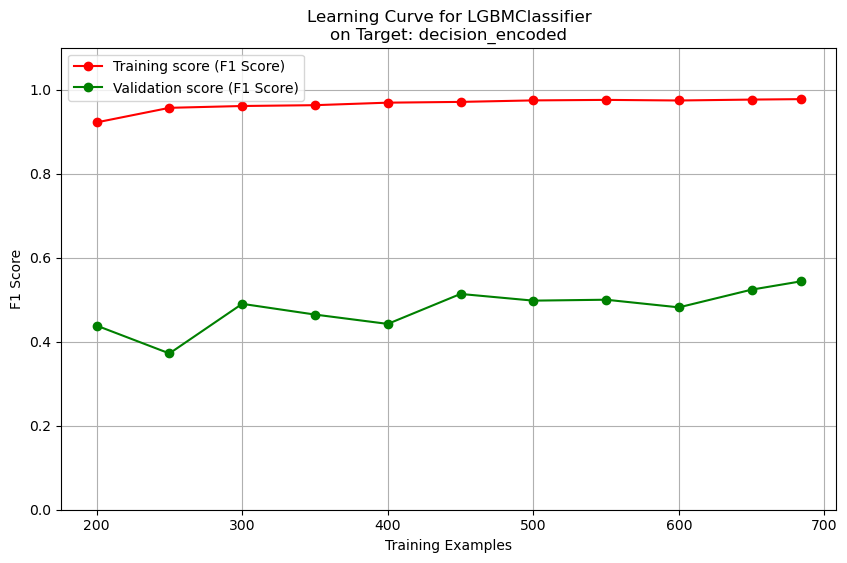

In [ ]:
if not X_train.empty and not X_val.empty: # Ensure main training and validation data are available
    print("\n--- Generating Learning Curves (Using Best Params from Initial Tuning) ---")
    
    min_train_size_lc = 200 
    step_size_lc = 50
    actual_max_train_samples = X_train.shape[0]

    if actual_max_train_samples == 0:
        print("Skipping learning curves: X_train is empty.")
        train_sizes = np.array([]) # Ensure train_sizes is empty if skipping
    else:
        if min_train_size_lc > actual_max_train_samples:
            print(f"Warning: Min training size for LC ({min_train_size_lc}) > available samples ({actual_max_train_samples}).")
            if actual_max_train_samples < step_size_lc and actual_max_train_samples > 0:
                train_sizes = np.array([actual_max_train_samples])
                print(f"Adjusting to single training size: {actual_max_train_samples}")
            elif actual_max_train_samples >= step_size_lc :
                 min_train_size_lc = step_size_lc 
                 train_sizes = np.arange(min_train_size_lc, actual_max_train_samples + 1, step_size_lc)
                 if actual_max_train_samples not in train_sizes :
                     train_sizes = np.append(train_sizes, actual_max_train_samples)
                 train_sizes = np.unique(train_sizes[train_sizes <= actual_max_train_samples])
                 print(f"Adjusting training sizes to start from {min_train_size_lc}.")
            else: 
                train_sizes = np.array([])
                print("Skipping LC: Not enough training data for meaningful curve generation.")
        else: 
            train_sizes = np.arange(min_train_size_lc, actual_max_train_samples + 1, step_size_lc)
            if actual_max_train_samples not in train_sizes:
                 train_sizes = np.append(train_sizes, actual_max_train_samples)
            train_sizes = np.unique(train_sizes[train_sizes <= actual_max_train_samples])

        if train_sizes.size == 0 and actual_max_train_samples > 0 : 
            train_sizes = np.array([actual_max_train_samples])
        elif train_sizes.size == 0:
             print("Skipping LC: No valid training sizes determined.")

    # --- REGRESSION LEARNING CURVES (R2 Score) ---
    if train_sizes.size > 0: # Proceed only if train_sizes is not empty
        for target_reg_col in processed_target_cols_regression:
            print(f"\nLearning Curves for Regression Target: {target_reg_col} (Metric: R2 Score)")
            current_y_train_full_reg = y_train_reg[target_reg_col]
            current_y_val_full_reg = y_val_reg[target_reg_col]

            for model_name, (model_template, _) in models_reg.items():
                train_scores, val_scores = [], []
                
                model_config_params = {}
                # Check if results and specific model entry exist before accessing "Best Params"
                if results.get(target_reg_col) and results[target_reg_col].get(model_name) and \
                   isinstance(results[target_reg_col][model_name].get("Best Params"), dict):
                    model_config_params = results[target_reg_col][model_name]["Best Params"]
                elif model_name in ["MeanPredictor", "LinearRegression"]: # Baselines or models with no grid params
                     pass # Use default init params
                else:
                    print(f"  Warning: Best params not found or not a dict for {model_name} on {target_reg_col}. Using default model parameters for learning curve.")

                current_model_lc = model_template.__class__(**model_template.get_params(deep=False))
                if model_config_params: 
                    try: current_model_lc.set_params(**model_config_params)
                    except Exception as e_set_param: print(f"Warning: Could not set params {model_config_params} for {model_name} on {target_reg_col} for LC. Error: {e_set_param}")
                
                print(f"  Model: {model_name}")
                for size in train_sizes:
                    if size == 0 or size > actual_max_train_samples: continue
                    X_train_subset = X_train.iloc[:int(size)]; y_train_subset = current_y_train_full_reg.iloc[:int(size)]
                    if y_train_subset.empty or (y_train_subset.nunique() < 2 and model_name != "MeanPredictor"):
                        train_scores.append(np.nan); val_scores.append(np.nan); continue
                    if X_train_subset.empty:
                        train_scores.append(np.nan); val_scores.append(np.nan); continue
                    try:
                        current_model_lc.fit(X_train_subset, y_train_subset)
                        y_train_pred_lc = current_model_lc.predict(X_train_subset)
                        train_scores.append(r2_score(y_train_subset, y_train_pred_lc))
                        if not X_val.empty and not current_y_val_full_reg.empty:
                            y_val_pred_lc = current_model_lc.predict(X_val)
                            val_scores.append(r2_score(current_y_val_full_reg, y_val_pred_lc))
                        else: val_scores.append(np.nan)
                    except Exception as e_lc:
                        print(f"    Error during LC point for size {size} with {model_name}: {e_lc}")
                        train_scores.append(np.nan); val_scores.append(np.nan)
                
                if train_sizes.size > 0 and (any(not np.isnan(s) for s in train_scores) or any(not np.isnan(s) for s in val_scores)):
                    plt.figure(figsize=(10, 6))
                    plt.plot(train_sizes[:len(train_scores)], train_scores, 'o-', color="r", label="Training score (R2)")
                    plt.plot(train_sizes[:len(val_scores)], val_scores, 'o-', color="g", label="Validation score (R2)")
                    plt.title(f"Learning Curve for {model_name}\non Target: {target_reg_col}")
                    plt.xlabel("Training Examples"); plt.ylabel("R2 Score"); plt.legend(loc="best"); plt.grid(True); plt.ylim([-0.1, 1.1]); plt.show()

        # --- CLASSIFICATION LEARNING CURVES (F1 Score) ---
        classification_targets_for_lc = {
            target_col_ethics: (y_train_clf_ethics, y_val_clf_ethics),
            target_col_decision_encoded: (y_train_clf_decision, y_val_clf_decision)
        }

        for target_clf_lc_var, (current_y_train_clf_full, current_y_val_clf_full) in classification_targets_for_lc.items():
            print(f"\nLearning Curves for Classification Target: {target_clf_lc_var} (Metric: F1 Score)")

            for model_name, (model_template, _) in models_clf.items():
                train_scores_clf, val_scores_clf = [], []
                model_config_params_clf = {}
                if results.get(target_clf_lc_var) and results[target_clf_lc_var].get(model_name) and \
                   isinstance(results[target_clf_lc_var][model_name].get("Best Params"), dict):
                    model_config_params_clf = results[target_clf_lc_var][model_name]["Best Params"]
                elif model_name == "MajorityClass": pass
                else: print(f"  Warning: Best params not found for {model_name} on {target_clf_lc_var}. Using default for LC.")
                
                current_model_lc_clf = model_template.__class__(**model_template.get_params(deep=False))
                if model_config_params_clf:
                    try: current_model_lc_clf.set_params(**model_config_params_clf)
                    except Exception as e_set_param_clf: print(f"Warning: Could not set params for {model_name} on {target_clf_lc_var} for LC. Error: {e_set_param_clf}")
                
                print(f"  Model: {model_name}")
                for size in train_sizes:
                    if size == 0 or size > actual_max_train_samples: continue
                    X_train_subset_clf = X_train.iloc[:int(size)]; y_train_subset_clf = current_y_train_clf_full.iloc[:int(size)]
                    if y_train_subset_clf.empty or X_train_subset_clf.empty or y_train_subset_clf.nunique() < 1:
                        train_scores_clf.append(np.nan); val_scores_clf.append(np.nan); continue
                    if y_train_subset_clf.nunique() < 2 and model_name not in ["MajorityClass"]: print(f"    Warning: Only one class in training subset size {size} for {model_name}. F1 may be 0.")
                    try:
                        current_model_lc_clf.fit(X_train_subset_clf, y_train_subset_clf)
                        y_train_pred_lc_clf = current_model_lc_clf.predict(X_train_subset_clf)
                        train_scores_clf.append(f1_score(y_train_subset_clf, y_train_pred_lc_clf, zero_division=0))
                        if not X_val.empty and not current_y_val_clf_full.empty:
                            y_val_pred_lc_clf = current_model_lc_clf.predict(X_val)
                            val_scores_clf.append(f1_score(current_y_val_clf_full, y_val_pred_lc_clf, zero_division=0))
                        else: val_scores_clf.append(np.nan)
                    except Exception as e_lc_clf:
                        print(f"    Error during LC point for size {size} with {model_name}: {e_lc_clf}")
                        train_scores_clf.append(np.nan); val_scores_clf.append(np.nan)
                
                if train_sizes.size > 0 and (any(not np.isnan(s) for s in train_scores_clf) or any(not np.isnan(s) for s in val_scores_clf)):
                    plt.figure(figsize=(10, 6))
                    plt.plot(train_sizes[:len(train_scores_clf)], train_scores_clf, 'o-', color="r", label="Training score (F1 Score)")
                    plt.plot(train_sizes[:len(val_scores_clf)], val_scores_clf, 'o-', color="g", label="Validation score (F1 Score)")
                    plt.title(f"Learning Curve for {model_name}\non Target: {target_clf_lc_var}")
                    plt.xlabel("Training Examples"); plt.ylabel("F1 Score"); plt.legend(loc="best"); plt.grid(True); plt.ylim([0.0, 1.1]); plt.show()
    else: # This else corresponds to "if train_sizes.size > 0"
        print("Skipping Learning Curve generation as no valid training sizes were determined (e.g. X_train too small).")

else: # This else corresponds to "if not X_train.empty and not X_val.empty"
    print("Skipping Learning Curve generation as X_train or X_val is empty.")

# --- End of Cell 8 ---
